# License Plate Detection - Data Collection and Exploration
This notebook trains the License Plate Detector model using the Tensorflow Object Detection API.

Main steps:
- Download the pre-trained model from the detection model zoo, which is needed for the training
- Train a finetuned model for License Plate Detection
- Convert the finetuned model into a TFLite model that can be used by the Android app
- Test the trained License Plate Detection model

The following diagram shows the directory structure that is created when executing the individual steps of this notebook:

```
<project_dir>
├── config
│   ├── plate_detection
│   │   ├── labels_map.pbtxt
│   │   ├── ssd_mobilenet_v2.config
│   │   ├── ssdlite_mobilenet_v2_coco.config
│   │   ├── ...
│   :   :
├── data
│   ├── plate_detection
│   │   ├── annotations
│   │   ├── images
│   │   │   ├── ger
│   │   │   │   ├── A-CR655.jpg
│   │   │   │   ├── A-MB1012.jpg
│   │   │   │   :
│   │   │   ├── other
│   │   │   :
│   │   ├── test_images
│   │   ├── train.record
│   │   ├── eval.record
│   │   ├── labels.csv
│   :   :
│       
├── output
│   ├── plate_detection
│   │   ├──models 
│   │   │   ├── ssd_mobilenet_v2_320x320_coco17_tpu-8
│   │   │   │   ├── checkpoint
│   │   │   │   ├── checkpoints
│   │   │   │   │   ├── model.ckpt.data-00000-of-00001
│   │   │   │   │   ├── model.ckpt.index
│   │   │   │   │   ├── model.ckpt.meta
│   │   │   │   └── saved_model
│   │   │   │       ├── saved_model.pb
│   │   │   │       └── variables
│   │   │   │
│   │   │   │   ├── fine_tuned_models
│   │   │   │   ├── frozen_inference_graph.pb
│   │   │   :   :
│   │   │   │   ├── tflite_graph.pb
│   │   │   │   ├── tflite_graph.pbtxt
│   │   │   │   ├── glpd-model.tflite
:   :   :
```

Import common modules...

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import matplotlib

from distutils.version import StrictVersion
from matplotlib import pyplot as plt
from PIL import Image

Check the Tensorflow version...

In [2]:
print ("Tensorflow: {}".format(tf.__version__))

if StrictVersion(tf.__version__.split('-')[0]) < StrictVersion('2.4.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v2.4.0')

if StrictVersion(tf.__version__.split('-')[0]) >= StrictVersion('3.0.0'):
    raise ImportError('Please downgrade your TensorFlow installation to v2.4.*.')

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

Tensorflow: 2.4.0
GPU device: /device:GPU:0


Environment setup for the Tensorflow Object Detection API

In [3]:
os.chdir(os.path.join(os.getcwd(), 'models/research'))
working_dir = os.getcwd()

sys.path.append(working_dir)
sys.path.append(working_dir + "/slim")

path = working_dir + ';' + working_dir + '/slim' + ';' + working_dir + '/object_detection'
os.environ['PYTHONPATH'] = path

os.chdir(os.path.join(os.getcwd(), 'object_detection'))

Import the modules form the Tensorflow Object Detection API

In [4]:
import object_detection

### Model preparation
The [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) requires a pretrained model as a basis for the training. Depending on the requirements, a suitable model must be selected from the [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). This model must be downloaded into the `models` directory of the object detection api and unpacked there before the training. 

For this project I use the `ssd_mobilenet_v2_320x320_coco17_tpu-8` model, because it has a good balance between accuracy and speed, which is important for use with a mobile device. However, by adjusting the variables `MODEL` and `PIPELINE_CONFING_FILENAME`, other pretrained models can also be used for training.

Furthermore, the number of classes to be trained `NUM_CLASSES` must be defined. Currently, our data collection only contains pictures of German license plates of class `GER`, therefore the number of classes is set to `1`. 

In [5]:
# choose pretrained model
MODEL = 'ssd_mobilenet_v2_320x320_coco17_tpu-8'
PIPELINE_CONFING_FILENAME = 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config'

NUM_CLASSES = 1

Define variables for often used directories and files

In [6]:
# ****************** don't edit ******************

# What model to download.
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'

# List of the strings that is used to add correct label for each box.
DETECTION_COFIG_DIR = os.path.normpath('../../../config/plate_detection')
PATH_TO_LABELS = os.path.normpath(os.path.join(DETECTION_COFIG_DIR, 'label_map.txt'))

PIPELINE_CONFING_FILEPATH = os.path.join(DETECTION_COFIG_DIR, PIPELINE_CONFING_FILENAME)

OUTPUT_DIR = os.path.normpath('../../../output/plate_detection')
MODELS_DIR = os.path.normpath(os.path.join(OUTPUT_DIR, 'models'))
CHECKPOINTS_DIR = os.path.normpath(os.path.join(MODELS_DIR, MODEL, 'checkpoints'))
PATH_TO_FROZEN_GRAPH = os.path.normpath(os.path.join(OUTPUT_DIR, 'saved_model'))
TFLITE_MODEL_PATH = os.path.normpath(os.path.join(OUTPUT_DIR, 'glpd-model.tflite'))

print ('Labels file:           {}'.format(PATH_TO_LABELS))
print ('Pipeline config file:  {}'.format(PIPELINE_CONFING_FILEPATH))
print ('Checkpoints directory: {}'.format(CHECKPOINTS_DIR))
print ('Frozen model file:     {}'.format(PATH_TO_FROZEN_GRAPH))
print ('TFLite model file:     {}'.format(TFLITE_MODEL_PATH))

Labels file:           ..\..\..\config\plate_detection\label_map.txt
Pipeline config file:  ..\..\..\config\plate_detection\ssd_mobilenet_v2_320x320_coco17_tpu-8.config
Checkpoints directory: ..\..\..\output\plate_detection\models\ssd_mobilenet_v2_320x320_coco17_tpu-8\checkpoints
Frozen model file:     ..\..\..\output\plate_detection\saved_model
TFLite model file:     ..\..\..\output\plate_detection\glpd-model.tflite


# Train License Plate Detection Model
This section describes the necessary steps to train the License Plate Detection model and convert it into a TFLite model that can be used by the Android app.

**NOTE:** If you have already trained and exported the license plate detection model, you can skip the training- and export steps and proceed directly with testing...

### Download Pretrained Model
Download and extract the pretrained model into the models directory of the object detection api. 

**NOTE:** This step only needs to be done once if the pretrained model has not been downloaded yet!

In [25]:
MODEL_ZIP = os.path.join(MODELS_DIR, MODEL_FILE)
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_ZIP)
tar_file = tarfile.open(MODEL_ZIP)
tar_file.extractall(os.path.join(os.getcwd(), MODELS_DIR))
tar_file.close()

### Train Finetuned Model

Starts the training of the finetuned detection model. This step may take several hours, depending on the computing power of your computer.

You can monitor the training process with `Tensorboard` by running the command `tensorboard --logdir=%CHECKPOINTS_DIR%` in another console. The training process can optionally be interrupted as soon as the desired accuracy is reached.

The parameter `pipeline_config_path` refers to the pipeline configuration file for the training, `model_dir` determines in which directory the trained model is stored.

In [7]:
%run model_main_tf2.py --pipeline_config_path={PIPELINE_CONFING_FILEPATH} --model_dir={CHECKPOINTS_DIR} --sample_1_of_n_eval_examples=40 --checkpoint_every_n=100

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


I0111 17:36:00.142713 20360 mirrored_strategy.py:350] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Maybe overwriting train_steps: None


I0111 17:36:00.162797 20360 config_util.py:552] Maybe overwriting train_steps: None


INFO:tensorflow:Maybe overwriting use_bfloat16: False


I0111 17:36:00.164761 20360 config_util.py:552] Maybe overwriting use_bfloat16: False


Instructions for updating:
rename to distribute_datasets_from_function


W0111 17:36:00.653230 20360 deprecation.py:333] From c:\users\andreas\anaconda3\envs\tf2.4\lib\site-packages\object_detection\model_lib_v2.py:522: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function


INFO:tensorflow:Reading unweighted datasets: ['../../../data/plate_detection/train.tfrecord']


I0111 17:36:00.680230 20360 dataset_builder.py:148] Reading unweighted datasets: ['../../../data/plate_detection/train.tfrecord']


INFO:tensorflow:Reading record datasets for input file: ['../../../data/plate_detection/train.tfrecord']


I0111 17:36:00.686223 20360 dataset_builder.py:77] Reading record datasets for input file: ['../../../data/plate_detection/train.tfrecord']


INFO:tensorflow:Number of filenames to read: 1


I0111 17:36:00.686223 20360 dataset_builder.py:78] Number of filenames to read: 1


W0111 17:36:00.688231 20360 dataset_builder.py:85] num_readers has been reduced to 1 to match input file shards.


Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.


W0111 17:36:00.693200 20360 deprecation.py:333] From c:\users\andreas\anaconda3\envs\tf2.4\lib\site-packages\object_detection\builders\dataset_builder.py:99: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.


Instructions for updating:
Use `tf.data.Dataset.map()


W0111 17:36:00.732811 20360 deprecation.py:333] From c:\users\andreas\anaconda3\envs\tf2.4\lib\site-packages\object_detection\builders\dataset_builder.py:221: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


W0111 17:36:05.734570 20360 deprecation.py:333] From c:\users\andreas\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\util\dispatch.py:201: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


W0111 17:36:08.108182 20360 deprecation.py:333] From c:\users\andreas\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\util\dispatch.py:201: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


Instructions for updating:
Use `tf.cast` instead.


W0111 17:36:10.196899 20360 deprecation.py:333] From c:\users\andreas\anaconda3\envs\tf2.4\lib\site-packages\object_detection\inputs.py:281: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
c:\users\andreas\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


INFO:tensorflow:depth of additional conv before box predictor: 0


I0111 17:36:19.560939  3848 convolutional_keras_box_predictor.py:153] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0111 17:36:19.560939  3848 convolutional_keras_box_predictor.py:153] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0111 17:36:19.560939  3848 convolutional_keras_box_predictor.py:153] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0111 17:36:19.560939  3848 convolutional_keras_box_predictor.py:153] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0111 17:36:19.574353  3848 convolutional_keras_box_predictor.py:153] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0111 17:36:19.575352  3848 convolutional_keras_box_predictor.py:153] depth of additional conv before box predictor: 0


W0111 17:36:45.368837 20360 util.py:160] Unresolved object in checkpoint: (root).model._groundtruth_lists


W0111 17:36:45.368837 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor


W0111 17:36:45.368837 20360 util.py:160] Unresolved object in checkpoint: (root).model._batched_prediction_tensor_names


W0111 17:36:45.368837 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads


W0111 17:36:45.368837 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._sorted_head_names


W0111 17:36:45.375830 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._shared_nets


W0111 17:36:45.376829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings


W0111 17:36:45.376829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background


W0111 17:36:45.378829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._shared_nets.0


W0111 17:36:45.379828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._shared_nets.1


W0111 17:36:45.380829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._shared_nets.2


W0111 17:36:45.381829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._shared_nets.3


W0111 17:36:45.381829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._shared_nets.4


W0111 17:36:45.382828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._shared_nets.5


W0111 17:36:45.383832 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.0


W0111 17:36:45.385830 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.1


W0111 17:36:45.386829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.2


W0111 17:36:45.387829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.3


W0111 17:36:45.389829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.4


W0111 17:36:45.390830 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.5


W0111 17:36:45.391829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.0


W0111 17:36:45.392830 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.1


W0111 17:36:45.393829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.2


W0111 17:36:45.394829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.3


W0111 17:36:45.395829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.4


W0111 17:36:45.396829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.5


W0111 17:36:45.396829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.0._box_encoder_layers


W0111 17:36:45.397829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.1._box_encoder_layers


W0111 17:36:45.398828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.2._box_encoder_layers


W0111 17:36:45.398828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.3._box_encoder_layers


W0111 17:36:45.399829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.4._box_encoder_layers


W0111 17:36:45.400828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.5._box_encoder_layers


W0111 17:36:45.400828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.0._class_predictor_layers


W0111 17:36:45.401829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.1._class_predictor_layers


W0111 17:36:45.402829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.2._class_predictor_layers


W0111 17:36:45.402829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.3._class_predictor_layers


W0111 17:36:45.403829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.4._class_predictor_layers


W0111 17:36:45.404829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.5._class_predictor_layers


W0111 17:36:45.404829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.0._box_encoder_layers.0


W0111 17:36:45.405829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.1._box_encoder_layers.0


W0111 17:36:45.406829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.2._box_encoder_layers.0


W0111 17:36:45.406829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.3._box_encoder_layers.0


W0111 17:36:45.407829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.4._box_encoder_layers.0


W0111 17:36:45.408830 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.5._box_encoder_layers.0


W0111 17:36:45.412830 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.0._class_predictor_layers.0


W0111 17:36:45.413829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.1._class_predictor_layers.0


W0111 17:36:45.415829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.2._class_predictor_layers.0


W0111 17:36:45.416829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.3._class_predictor_layers.0


W0111 17:36:45.417830 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.4._class_predictor_layers.0


W0111 17:36:45.418829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.5._class_predictor_layers.0


W0111 17:36:45.419829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.0._box_encoder_layers.0.kernel


W0111 17:36:45.420829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.0._box_encoder_layers.0.bias


W0111 17:36:45.421829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.1._box_encoder_layers.0.kernel


W0111 17:36:45.422828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.1._box_encoder_layers.0.bias


W0111 17:36:45.423830 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.2._box_encoder_layers.0.kernel


W0111 17:36:45.424829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.2._box_encoder_layers.0.bias


W0111 17:36:45.425829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.3._box_encoder_layers.0.kernel


W0111 17:36:45.426829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.3._box_encoder_layers.0.bias


W0111 17:36:45.426829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.4._box_encoder_layers.0.kernel


W0111 17:36:45.428828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.4._box_encoder_layers.0.bias


W0111 17:36:45.428828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.5._box_encoder_layers.0.kernel


W0111 17:36:45.429829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.box_encodings.5._box_encoder_layers.0.bias


W0111 17:36:45.430829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.0._class_predictor_layers.0.kernel


W0111 17:36:45.432830 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.0._class_predictor_layers.0.bias


W0111 17:36:45.433829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.1._class_predictor_layers.0.kernel


W0111 17:36:45.434829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.1._class_predictor_layers.0.bias


W0111 17:36:45.435829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.2._class_predictor_layers.0.kernel


W0111 17:36:45.436829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.2._class_predictor_layers.0.bias


W0111 17:36:45.436829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.3._class_predictor_layers.0.kernel


W0111 17:36:45.437828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.3._class_predictor_layers.0.bias


W0111 17:36:45.438829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.4._class_predictor_layers.0.kernel


W0111 17:36:45.439829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.4._class_predictor_layers.0.bias


W0111 17:36:45.440829 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.5._class_predictor_layers.0.kernel


W0111 17:36:45.441828 20360 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background.5._class_predictor_layers.0.bias


W0111 17:36:45.442829 20360 util.py:168] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.016170 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.016170 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.025458 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.027458 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.030458 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.033462 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.036459 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.038469 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.041458 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


I0111 17:36:46.043470 20360 cross_device_ops.py:563] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Instructions for updating:
Use fn_output_signature instead


W0111 17:36:53.660317  8856 deprecation.py:531] From c:\users\andreas\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\util\deprecation.py:605: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Step 100 per-step time 0.370s loss=0.803


I0111 17:37:54.501013 20360 model_lib_v2.py:648] Step 100 per-step time 0.370s loss=0.803


INFO:tensorflow:Step 200 per-step time 0.400s loss=0.333


I0111 17:38:36.014318 20360 model_lib_v2.py:648] Step 200 per-step time 0.400s loss=0.333


INFO:tensorflow:Step 300 per-step time 0.417s loss=0.373


I0111 17:39:17.159446 20360 model_lib_v2.py:648] Step 300 per-step time 0.417s loss=0.373


INFO:tensorflow:Step 400 per-step time 0.385s loss=0.322


I0111 17:39:58.442051 20360 model_lib_v2.py:648] Step 400 per-step time 0.385s loss=0.322


INFO:tensorflow:Step 500 per-step time 0.405s loss=0.415


I0111 17:40:40.002685 20360 model_lib_v2.py:648] Step 500 per-step time 0.405s loss=0.415


INFO:tensorflow:Step 600 per-step time 0.417s loss=0.265


I0111 17:41:21.165749 20360 model_lib_v2.py:648] Step 600 per-step time 0.417s loss=0.265


INFO:tensorflow:Step 700 per-step time 0.417s loss=0.220


I0111 17:42:02.088319 20360 model_lib_v2.py:648] Step 700 per-step time 0.417s loss=0.220


INFO:tensorflow:Step 800 per-step time 0.406s loss=0.243


I0111 17:42:43.047877 20360 model_lib_v2.py:648] Step 800 per-step time 0.406s loss=0.243


INFO:tensorflow:Step 900 per-step time 0.400s loss=0.245


I0111 17:43:24.514797 20360 model_lib_v2.py:648] Step 900 per-step time 0.400s loss=0.245


INFO:tensorflow:Step 1000 per-step time 0.416s loss=0.295


I0111 17:44:05.917759 20360 model_lib_v2.py:648] Step 1000 per-step time 0.416s loss=0.295


INFO:tensorflow:Step 1100 per-step time 0.410s loss=0.204


I0111 17:44:47.199843 20360 model_lib_v2.py:648] Step 1100 per-step time 0.410s loss=0.204


INFO:tensorflow:Step 1200 per-step time 0.417s loss=0.219


I0111 17:45:28.379232 20360 model_lib_v2.py:648] Step 1200 per-step time 0.417s loss=0.219


INFO:tensorflow:Step 1300 per-step time 0.408s loss=0.206


I0111 17:46:09.639945 20360 model_lib_v2.py:648] Step 1300 per-step time 0.408s loss=0.206


INFO:tensorflow:Step 1400 per-step time 0.401s loss=0.216


I0111 17:46:50.937901 20360 model_lib_v2.py:648] Step 1400 per-step time 0.401s loss=0.216


INFO:tensorflow:Step 1500 per-step time 0.418s loss=0.208


I0111 17:47:32.216373 20360 model_lib_v2.py:648] Step 1500 per-step time 0.418s loss=0.208


INFO:tensorflow:Step 1600 per-step time 0.416s loss=0.204


I0111 17:48:13.454950 20360 model_lib_v2.py:648] Step 1600 per-step time 0.416s loss=0.204


INFO:tensorflow:Step 1700 per-step time 0.418s loss=0.175


I0111 17:48:55.392623 20360 model_lib_v2.py:648] Step 1700 per-step time 0.418s loss=0.175


INFO:tensorflow:Step 1800 per-step time 0.401s loss=0.173


I0111 17:49:36.880880 20360 model_lib_v2.py:648] Step 1800 per-step time 0.401s loss=0.173


INFO:tensorflow:Step 1900 per-step time 0.417s loss=0.203


I0111 17:50:18.199736 20360 model_lib_v2.py:648] Step 1900 per-step time 0.417s loss=0.203


INFO:tensorflow:Step 2000 per-step time 0.398s loss=0.163


I0111 17:50:59.597762 20360 model_lib_v2.py:648] Step 2000 per-step time 0.398s loss=0.163


INFO:tensorflow:Step 2100 per-step time 0.416s loss=0.211


I0111 17:51:40.829622 20360 model_lib_v2.py:648] Step 2100 per-step time 0.416s loss=0.211


INFO:tensorflow:Step 2200 per-step time 0.382s loss=0.200


I0111 17:52:22.060811 20360 model_lib_v2.py:648] Step 2200 per-step time 0.382s loss=0.200


INFO:tensorflow:Step 2300 per-step time 0.410s loss=0.198


I0111 17:53:03.370661 20360 model_lib_v2.py:648] Step 2300 per-step time 0.410s loss=0.198


INFO:tensorflow:Step 2400 per-step time 0.405s loss=0.160


I0111 17:53:44.687227 20360 model_lib_v2.py:648] Step 2400 per-step time 0.405s loss=0.160


INFO:tensorflow:Step 2500 per-step time 0.425s loss=0.178


I0111 17:54:26.121573 20360 model_lib_v2.py:648] Step 2500 per-step time 0.425s loss=0.178


INFO:tensorflow:Step 2600 per-step time 0.432s loss=0.175


I0111 17:55:07.723840 20360 model_lib_v2.py:648] Step 2600 per-step time 0.432s loss=0.175


INFO:tensorflow:Step 2700 per-step time 0.372s loss=0.192


I0111 17:55:48.916798 20360 model_lib_v2.py:648] Step 2700 per-step time 0.372s loss=0.192


INFO:tensorflow:Step 2800 per-step time 0.433s loss=0.154


I0111 17:56:30.376645 20360 model_lib_v2.py:648] Step 2800 per-step time 0.433s loss=0.154


INFO:tensorflow:Step 2900 per-step time 0.398s loss=0.145


I0111 17:57:11.752174 20360 model_lib_v2.py:648] Step 2900 per-step time 0.398s loss=0.145


INFO:tensorflow:Step 3000 per-step time 0.402s loss=0.191


I0111 17:57:53.158868 20360 model_lib_v2.py:648] Step 3000 per-step time 0.402s loss=0.191


INFO:tensorflow:Step 3100 per-step time 0.425s loss=0.153


I0111 17:58:34.484592 20360 model_lib_v2.py:648] Step 3100 per-step time 0.425s loss=0.153


INFO:tensorflow:Step 3200 per-step time 0.400s loss=0.178


I0111 17:59:15.647144 20360 model_lib_v2.py:648] Step 3200 per-step time 0.400s loss=0.178


INFO:tensorflow:Step 3300 per-step time 0.416s loss=0.211


I0111 17:59:56.772453 20360 model_lib_v2.py:648] Step 3300 per-step time 0.416s loss=0.211


INFO:tensorflow:Step 3400 per-step time 0.417s loss=0.162


I0111 18:00:38.327387 20360 model_lib_v2.py:648] Step 3400 per-step time 0.417s loss=0.162


INFO:tensorflow:Step 3500 per-step time 0.390s loss=0.202


I0111 18:01:20.208678 20360 model_lib_v2.py:648] Step 3500 per-step time 0.390s loss=0.202


INFO:tensorflow:Step 3600 per-step time 0.417s loss=0.162


I0111 18:02:03.608577 20360 model_lib_v2.py:648] Step 3600 per-step time 0.417s loss=0.162


INFO:tensorflow:Step 3700 per-step time 0.403s loss=0.170


I0111 18:02:46.138606 20360 model_lib_v2.py:648] Step 3700 per-step time 0.403s loss=0.170


INFO:tensorflow:Step 3800 per-step time 0.416s loss=0.160


I0111 18:03:27.882629 20360 model_lib_v2.py:648] Step 3800 per-step time 0.416s loss=0.160


INFO:tensorflow:Step 3900 per-step time 0.426s loss=0.157


I0111 18:04:09.711800 20360 model_lib_v2.py:648] Step 3900 per-step time 0.426s loss=0.157


INFO:tensorflow:Step 4000 per-step time 0.379s loss=0.155


I0111 18:04:52.014847 20360 model_lib_v2.py:648] Step 4000 per-step time 0.379s loss=0.155


INFO:tensorflow:Step 4100 per-step time 0.407s loss=0.168


I0111 18:05:33.854119 20360 model_lib_v2.py:648] Step 4100 per-step time 0.407s loss=0.168


INFO:tensorflow:Step 4200 per-step time 0.401s loss=0.231


I0111 18:06:15.788579 20360 model_lib_v2.py:648] Step 4200 per-step time 0.401s loss=0.231


INFO:tensorflow:Step 4300 per-step time 0.385s loss=0.156


I0111 18:06:57.680830 20360 model_lib_v2.py:648] Step 4300 per-step time 0.385s loss=0.156


INFO:tensorflow:Step 4400 per-step time 0.386s loss=0.186


I0111 18:07:39.531886 20360 model_lib_v2.py:648] Step 4400 per-step time 0.386s loss=0.186


INFO:tensorflow:Step 4500 per-step time 0.410s loss=0.170


I0111 18:08:20.985752 20360 model_lib_v2.py:648] Step 4500 per-step time 0.410s loss=0.170


INFO:tensorflow:Step 4600 per-step time 0.413s loss=0.150


I0111 18:09:02.554280 20360 model_lib_v2.py:648] Step 4600 per-step time 0.413s loss=0.150


INFO:tensorflow:Step 4700 per-step time 0.401s loss=0.143


I0111 18:09:44.370004 20360 model_lib_v2.py:648] Step 4700 per-step time 0.401s loss=0.143


INFO:tensorflow:Step 4800 per-step time 0.472s loss=0.171


I0111 18:10:25.916531 20360 model_lib_v2.py:648] Step 4800 per-step time 0.472s loss=0.171


INFO:tensorflow:Step 4900 per-step time 0.408s loss=0.172


I0111 18:11:07.583913 20360 model_lib_v2.py:648] Step 4900 per-step time 0.408s loss=0.172


INFO:tensorflow:Step 5000 per-step time 0.385s loss=0.178


I0111 18:11:49.244432 20360 model_lib_v2.py:648] Step 5000 per-step time 0.385s loss=0.178


INFO:tensorflow:Step 5100 per-step time 0.408s loss=0.135


I0111 18:12:30.548626 20360 model_lib_v2.py:648] Step 5100 per-step time 0.408s loss=0.135


INFO:tensorflow:Step 5200 per-step time 0.400s loss=0.138


I0111 18:13:11.699613 20360 model_lib_v2.py:648] Step 5200 per-step time 0.400s loss=0.138


INFO:tensorflow:Step 5300 per-step time 0.416s loss=0.169


I0111 18:13:53.328222 20360 model_lib_v2.py:648] Step 5300 per-step time 0.416s loss=0.169


INFO:tensorflow:Step 5400 per-step time 0.410s loss=0.158


I0111 18:14:34.735076 20360 model_lib_v2.py:648] Step 5400 per-step time 0.410s loss=0.158


INFO:tensorflow:Step 5500 per-step time 0.402s loss=0.119


I0111 18:15:16.063497 20360 model_lib_v2.py:648] Step 5500 per-step time 0.402s loss=0.119


INFO:tensorflow:Step 5600 per-step time 0.402s loss=0.142


I0111 18:15:57.490067 20360 model_lib_v2.py:648] Step 5600 per-step time 0.402s loss=0.142


INFO:tensorflow:Step 5700 per-step time 0.408s loss=0.160


I0111 18:16:39.630064 20360 model_lib_v2.py:648] Step 5700 per-step time 0.408s loss=0.160


INFO:tensorflow:Step 5800 per-step time 0.438s loss=0.134


I0111 18:17:21.196136 20360 model_lib_v2.py:648] Step 5800 per-step time 0.438s loss=0.134


INFO:tensorflow:Step 5900 per-step time 0.384s loss=0.136


I0111 18:18:02.784991 20360 model_lib_v2.py:648] Step 5900 per-step time 0.384s loss=0.136


INFO:tensorflow:Step 6000 per-step time 0.430s loss=0.162


I0111 18:18:44.468976 20360 model_lib_v2.py:648] Step 6000 per-step time 0.430s loss=0.162


INFO:tensorflow:Step 6100 per-step time 0.428s loss=0.130


I0111 18:19:26.071550 20360 model_lib_v2.py:648] Step 6100 per-step time 0.428s loss=0.130


INFO:tensorflow:Step 6200 per-step time 0.412s loss=0.176


I0111 18:20:07.615918 20360 model_lib_v2.py:648] Step 6200 per-step time 0.412s loss=0.176


INFO:tensorflow:Step 6300 per-step time 0.421s loss=0.129


I0111 18:20:48.807837 20360 model_lib_v2.py:648] Step 6300 per-step time 0.421s loss=0.129


INFO:tensorflow:Step 6400 per-step time 0.409s loss=0.141


I0111 18:21:29.937191 20360 model_lib_v2.py:648] Step 6400 per-step time 0.409s loss=0.141


INFO:tensorflow:Step 6500 per-step time 0.403s loss=0.172


I0111 18:22:11.587458 20360 model_lib_v2.py:648] Step 6500 per-step time 0.403s loss=0.172


INFO:tensorflow:Step 6600 per-step time 0.423s loss=0.153


I0111 18:22:52.842249 20360 model_lib_v2.py:648] Step 6600 per-step time 0.423s loss=0.153


INFO:tensorflow:Step 6700 per-step time 0.415s loss=0.140


I0111 18:23:34.655280 20360 model_lib_v2.py:648] Step 6700 per-step time 0.415s loss=0.140


INFO:tensorflow:Step 6800 per-step time 0.406s loss=0.151


I0111 18:24:16.543350 20360 model_lib_v2.py:648] Step 6800 per-step time 0.406s loss=0.151


INFO:tensorflow:Step 6900 per-step time 0.425s loss=0.144


I0111 18:24:58.210339 20360 model_lib_v2.py:648] Step 6900 per-step time 0.425s loss=0.144


INFO:tensorflow:Step 7000 per-step time 0.416s loss=0.132


I0111 18:25:39.735602 20360 model_lib_v2.py:648] Step 7000 per-step time 0.416s loss=0.132


INFO:tensorflow:Step 7100 per-step time 0.402s loss=0.130


I0111 18:26:21.019250 20360 model_lib_v2.py:648] Step 7100 per-step time 0.402s loss=0.130


INFO:tensorflow:Step 7200 per-step time 0.384s loss=0.156


I0111 18:27:02.277665 20360 model_lib_v2.py:648] Step 7200 per-step time 0.384s loss=0.156


INFO:tensorflow:Step 7300 per-step time 0.408s loss=0.138


I0111 18:27:43.281507 20360 model_lib_v2.py:648] Step 7300 per-step time 0.408s loss=0.138


INFO:tensorflow:Step 7400 per-step time 0.403s loss=0.128


I0111 18:28:24.780433 20360 model_lib_v2.py:648] Step 7400 per-step time 0.403s loss=0.128


INFO:tensorflow:Step 7500 per-step time 0.385s loss=0.120


I0111 18:29:06.290625 20360 model_lib_v2.py:648] Step 7500 per-step time 0.385s loss=0.120


INFO:tensorflow:Step 7600 per-step time 0.537s loss=0.138


I0111 18:30:04.661337 20360 model_lib_v2.py:648] Step 7600 per-step time 0.537s loss=0.138


INFO:tensorflow:Step 7700 per-step time 0.478s loss=0.147


I0111 18:30:52.012807 20360 model_lib_v2.py:648] Step 7700 per-step time 0.478s loss=0.147


INFO:tensorflow:Step 7800 per-step time 0.411s loss=0.134


I0111 18:31:37.380947 20360 model_lib_v2.py:648] Step 7800 per-step time 0.411s loss=0.134


INFO:tensorflow:Step 7900 per-step time 0.416s loss=0.119


I0111 18:32:19.636003 20360 model_lib_v2.py:648] Step 7900 per-step time 0.416s loss=0.119


INFO:tensorflow:Step 8000 per-step time 0.459s loss=0.137


I0111 18:33:02.762525 20360 model_lib_v2.py:648] Step 8000 per-step time 0.459s loss=0.137


INFO:tensorflow:Step 8100 per-step time 3.523s loss=0.163


I0111 18:34:05.033079 20360 model_lib_v2.py:648] Step 8100 per-step time 3.523s loss=0.163


INFO:tensorflow:Step 8200 per-step time 0.827s loss=0.137


I0111 18:35:05.740380 20360 model_lib_v2.py:648] Step 8200 per-step time 0.827s loss=0.137


INFO:tensorflow:Step 8300 per-step time 0.409s loss=0.131


I0111 18:35:53.402205 20360 model_lib_v2.py:648] Step 8300 per-step time 0.409s loss=0.131


INFO:tensorflow:Step 8400 per-step time 0.561s loss=0.130


I0111 18:36:39.149558 20360 model_lib_v2.py:648] Step 8400 per-step time 0.561s loss=0.130


INFO:tensorflow:Step 8500 per-step time 0.422s loss=0.127


I0111 18:37:25.289959 20360 model_lib_v2.py:648] Step 8500 per-step time 0.422s loss=0.127


INFO:tensorflow:Step 8600 per-step time 0.425s loss=0.145


I0111 18:38:07.269177 20360 model_lib_v2.py:648] Step 8600 per-step time 0.425s loss=0.145


INFO:tensorflow:Step 8700 per-step time 0.394s loss=0.128


I0111 18:38:50.884468 20360 model_lib_v2.py:648] Step 8700 per-step time 0.394s loss=0.128


INFO:tensorflow:Step 8800 per-step time 0.401s loss=0.129


I0111 18:39:36.689440 20360 model_lib_v2.py:648] Step 8800 per-step time 0.401s loss=0.129


INFO:tensorflow:Step 8900 per-step time 0.451s loss=0.129


I0111 18:40:26.243145 20360 model_lib_v2.py:648] Step 8900 per-step time 0.451s loss=0.129


INFO:tensorflow:Step 9000 per-step time 1.132s loss=0.162


I0111 18:41:14.763538 20360 model_lib_v2.py:648] Step 9000 per-step time 1.132s loss=0.162


INFO:tensorflow:Step 9100 per-step time 0.419s loss=0.188


I0111 18:42:06.481717 20360 model_lib_v2.py:648] Step 9100 per-step time 0.419s loss=0.188


INFO:tensorflow:Step 9200 per-step time 0.410s loss=0.116


I0111 18:42:58.072772 20360 model_lib_v2.py:648] Step 9200 per-step time 0.410s loss=0.116


INFO:tensorflow:Step 9300 per-step time 0.407s loss=0.136


I0111 18:43:49.172017 20360 model_lib_v2.py:648] Step 9300 per-step time 0.407s loss=0.136


INFO:tensorflow:Step 9400 per-step time 0.494s loss=0.138


I0111 18:44:42.542974 20360 model_lib_v2.py:648] Step 9400 per-step time 0.494s loss=0.138


INFO:tensorflow:Step 9500 per-step time 0.505s loss=0.128


I0111 18:45:26.459966 20360 model_lib_v2.py:648] Step 9500 per-step time 0.505s loss=0.128


INFO:tensorflow:Step 9600 per-step time 0.406s loss=0.121


I0111 18:46:11.065751 20360 model_lib_v2.py:648] Step 9600 per-step time 0.406s loss=0.121


INFO:tensorflow:Step 9700 per-step time 0.405s loss=0.125


I0111 18:46:52.091666 20360 model_lib_v2.py:648] Step 9700 per-step time 0.405s loss=0.125


INFO:tensorflow:Step 9800 per-step time 0.417s loss=0.125


I0111 18:47:33.919488 20360 model_lib_v2.py:648] Step 9800 per-step time 0.417s loss=0.125


INFO:tensorflow:Step 9900 per-step time 0.402s loss=0.137


I0111 18:48:14.959586 20360 model_lib_v2.py:648] Step 9900 per-step time 0.402s loss=0.137


INFO:tensorflow:Step 10000 per-step time 0.417s loss=0.124


I0111 18:48:56.107075 20360 model_lib_v2.py:648] Step 10000 per-step time 0.417s loss=0.124


INFO:tensorflow:Step 10100 per-step time 0.399s loss=0.134


I0111 18:49:37.270585 20360 model_lib_v2.py:648] Step 10100 per-step time 0.399s loss=0.134


INFO:tensorflow:Step 10200 per-step time 0.378s loss=0.159


I0111 18:50:18.145334 20360 model_lib_v2.py:648] Step 10200 per-step time 0.378s loss=0.159


INFO:tensorflow:Step 10300 per-step time 0.416s loss=0.132


I0111 18:50:59.224024 20360 model_lib_v2.py:648] Step 10300 per-step time 0.416s loss=0.132


INFO:tensorflow:Step 10400 per-step time 0.397s loss=0.137


I0111 18:51:40.219141 20360 model_lib_v2.py:648] Step 10400 per-step time 0.397s loss=0.137


INFO:tensorflow:Step 10500 per-step time 0.401s loss=0.129


I0111 18:52:21.358415 20360 model_lib_v2.py:648] Step 10500 per-step time 0.401s loss=0.129


INFO:tensorflow:Step 10600 per-step time 0.412s loss=0.122


I0111 18:53:02.415629 20360 model_lib_v2.py:648] Step 10600 per-step time 0.412s loss=0.122


INFO:tensorflow:Step 10700 per-step time 0.416s loss=0.169


I0111 18:53:43.489645 20360 model_lib_v2.py:648] Step 10700 per-step time 0.416s loss=0.169


INFO:tensorflow:Step 10800 per-step time 0.416s loss=0.119


I0111 18:54:24.897270 20360 model_lib_v2.py:648] Step 10800 per-step time 0.416s loss=0.119


INFO:tensorflow:Step 10900 per-step time 0.416s loss=0.118


I0111 18:55:06.104595 20360 model_lib_v2.py:648] Step 10900 per-step time 0.416s loss=0.118


INFO:tensorflow:Step 11000 per-step time 0.423s loss=0.116


I0111 18:55:47.341022 20360 model_lib_v2.py:648] Step 11000 per-step time 0.423s loss=0.116


INFO:tensorflow:Step 11100 per-step time 0.434s loss=0.133


I0111 18:56:28.623052 20360 model_lib_v2.py:648] Step 11100 per-step time 0.434s loss=0.133


INFO:tensorflow:Step 11200 per-step time 0.401s loss=0.149


I0111 18:57:10.059420 20360 model_lib_v2.py:648] Step 11200 per-step time 0.401s loss=0.149


INFO:tensorflow:Step 11300 per-step time 0.403s loss=0.126


I0111 18:57:51.395440 20360 model_lib_v2.py:648] Step 11300 per-step time 0.403s loss=0.126


INFO:tensorflow:Step 11400 per-step time 0.379s loss=0.137


I0111 18:58:32.684706 20360 model_lib_v2.py:648] Step 11400 per-step time 0.379s loss=0.137


INFO:tensorflow:Step 11500 per-step time 0.416s loss=0.151


I0111 18:59:13.876109 20360 model_lib_v2.py:648] Step 11500 per-step time 0.416s loss=0.151


INFO:tensorflow:Step 11600 per-step time 0.394s loss=0.118


I0111 18:59:55.122113 20360 model_lib_v2.py:648] Step 11600 per-step time 0.394s loss=0.118


INFO:tensorflow:Step 11700 per-step time 0.430s loss=0.127


I0111 19:00:36.704521 20360 model_lib_v2.py:648] Step 11700 per-step time 0.430s loss=0.127


INFO:tensorflow:Step 11800 per-step time 0.401s loss=0.169


I0111 19:01:18.506835 20360 model_lib_v2.py:648] Step 11800 per-step time 0.401s loss=0.169


INFO:tensorflow:Step 11900 per-step time 0.405s loss=0.132


I0111 19:01:59.859928 20360 model_lib_v2.py:648] Step 11900 per-step time 0.405s loss=0.132


INFO:tensorflow:Step 12000 per-step time 0.416s loss=0.135


I0111 19:02:40.985387 20360 model_lib_v2.py:648] Step 12000 per-step time 0.416s loss=0.135


INFO:tensorflow:Step 12100 per-step time 0.417s loss=0.140


I0111 19:03:22.097109 20360 model_lib_v2.py:648] Step 12100 per-step time 0.417s loss=0.140


INFO:tensorflow:Step 12200 per-step time 0.411s loss=0.121


I0111 19:04:03.527023 20360 model_lib_v2.py:648] Step 12200 per-step time 0.411s loss=0.121


INFO:tensorflow:Step 12300 per-step time 0.401s loss=0.131


I0111 19:04:45.079264 20360 model_lib_v2.py:648] Step 12300 per-step time 0.401s loss=0.131


INFO:tensorflow:Step 12400 per-step time 0.400s loss=0.127


I0111 19:05:26.403128 20360 model_lib_v2.py:648] Step 12400 per-step time 0.400s loss=0.127


INFO:tensorflow:Step 12500 per-step time 0.401s loss=0.111


I0111 19:06:07.815075 20360 model_lib_v2.py:648] Step 12500 per-step time 0.401s loss=0.111


INFO:tensorflow:Step 12600 per-step time 0.415s loss=0.123


I0111 19:06:49.019437 20360 model_lib_v2.py:648] Step 12600 per-step time 0.415s loss=0.123


INFO:tensorflow:Step 12700 per-step time 0.412s loss=0.143


I0111 19:07:30.164724 20360 model_lib_v2.py:648] Step 12700 per-step time 0.412s loss=0.143


INFO:tensorflow:Step 12800 per-step time 0.401s loss=0.111


I0111 19:08:10.966087 20360 model_lib_v2.py:648] Step 12800 per-step time 0.401s loss=0.111


INFO:tensorflow:Step 12900 per-step time 0.385s loss=0.133


I0111 19:08:52.207943 20360 model_lib_v2.py:648] Step 12900 per-step time 0.385s loss=0.133


INFO:tensorflow:Step 13000 per-step time 0.416s loss=0.121


I0111 19:09:33.301741 20360 model_lib_v2.py:648] Step 13000 per-step time 0.416s loss=0.121


INFO:tensorflow:Step 13100 per-step time 0.400s loss=0.116


I0111 19:10:14.363358 20360 model_lib_v2.py:648] Step 13100 per-step time 0.400s loss=0.116


INFO:tensorflow:Step 13200 per-step time 0.385s loss=0.129


I0111 19:10:55.438010 20360 model_lib_v2.py:648] Step 13200 per-step time 0.385s loss=0.129


INFO:tensorflow:Step 13300 per-step time 0.417s loss=0.110


I0111 19:11:36.696105 20360 model_lib_v2.py:648] Step 13300 per-step time 0.417s loss=0.110


INFO:tensorflow:Step 13400 per-step time 0.432s loss=0.129


I0111 19:12:17.902226 20360 model_lib_v2.py:648] Step 13400 per-step time 0.432s loss=0.129


INFO:tensorflow:Step 13500 per-step time 0.383s loss=0.126


I0111 19:12:59.243569 20360 model_lib_v2.py:648] Step 13500 per-step time 0.383s loss=0.126


INFO:tensorflow:Step 13600 per-step time 0.401s loss=0.127


I0111 19:13:40.479915 20360 model_lib_v2.py:648] Step 13600 per-step time 0.401s loss=0.127


INFO:tensorflow:Step 13700 per-step time 0.418s loss=0.129


I0111 19:14:21.612178 20360 model_lib_v2.py:648] Step 13700 per-step time 0.418s loss=0.129


INFO:tensorflow:Step 13800 per-step time 0.413s loss=0.103


I0111 19:15:02.949680 20360 model_lib_v2.py:648] Step 13800 per-step time 0.413s loss=0.103


INFO:tensorflow:Step 13900 per-step time 0.401s loss=0.115


I0111 19:15:44.825773 20360 model_lib_v2.py:648] Step 13900 per-step time 0.401s loss=0.115


INFO:tensorflow:Step 14000 per-step time 0.401s loss=0.138


I0111 19:16:25.945682 20360 model_lib_v2.py:648] Step 14000 per-step time 0.401s loss=0.138


INFO:tensorflow:Step 14100 per-step time 0.396s loss=0.116


I0111 19:17:07.246545 20360 model_lib_v2.py:648] Step 14100 per-step time 0.396s loss=0.116


INFO:tensorflow:Step 14200 per-step time 0.416s loss=0.106


I0111 19:17:48.436707 20360 model_lib_v2.py:648] Step 14200 per-step time 0.416s loss=0.106


INFO:tensorflow:Step 14300 per-step time 0.402s loss=0.121


I0111 19:18:29.661036 20360 model_lib_v2.py:648] Step 14300 per-step time 0.402s loss=0.121


INFO:tensorflow:Step 14400 per-step time 0.416s loss=0.113


I0111 19:19:10.877283 20360 model_lib_v2.py:648] Step 14400 per-step time 0.416s loss=0.113


INFO:tensorflow:Step 14500 per-step time 0.423s loss=0.129


I0111 19:19:52.299465 20360 model_lib_v2.py:648] Step 14500 per-step time 0.423s loss=0.129


INFO:tensorflow:Step 14600 per-step time 0.450s loss=0.128


I0111 19:20:33.419459 20360 model_lib_v2.py:648] Step 14600 per-step time 0.450s loss=0.128


INFO:tensorflow:Step 14700 per-step time 0.401s loss=0.116


I0111 19:21:14.462898 20360 model_lib_v2.py:648] Step 14700 per-step time 0.401s loss=0.116


INFO:tensorflow:Step 14800 per-step time 0.417s loss=0.118


I0111 19:21:55.724785 20360 model_lib_v2.py:648] Step 14800 per-step time 0.417s loss=0.118


INFO:tensorflow:Step 14900 per-step time 0.415s loss=0.108


I0111 19:22:37.030953 20360 model_lib_v2.py:648] Step 14900 per-step time 0.415s loss=0.108


INFO:tensorflow:Step 15000 per-step time 0.401s loss=0.118


I0111 19:23:18.084897 20360 model_lib_v2.py:648] Step 15000 per-step time 0.401s loss=0.118


INFO:tensorflow:Step 15100 per-step time 0.416s loss=0.121


I0111 19:23:59.159206 20360 model_lib_v2.py:648] Step 15100 per-step time 0.416s loss=0.121


INFO:tensorflow:Step 15200 per-step time 0.391s loss=0.126


I0111 19:24:40.525457 20360 model_lib_v2.py:648] Step 15200 per-step time 0.391s loss=0.126


INFO:tensorflow:Step 15300 per-step time 0.402s loss=0.108


I0111 19:25:21.660932 20360 model_lib_v2.py:648] Step 15300 per-step time 0.402s loss=0.108


INFO:tensorflow:Step 15400 per-step time 0.401s loss=0.120


I0111 19:26:02.904810 20360 model_lib_v2.py:648] Step 15400 per-step time 0.401s loss=0.120


INFO:tensorflow:Step 15500 per-step time 0.392s loss=0.135


I0111 19:26:43.963353 20360 model_lib_v2.py:648] Step 15500 per-step time 0.392s loss=0.135


INFO:tensorflow:Step 15600 per-step time 0.413s loss=0.108


I0111 19:27:25.205242 20360 model_lib_v2.py:648] Step 15600 per-step time 0.413s loss=0.108


INFO:tensorflow:Step 15700 per-step time 0.401s loss=0.114


I0111 19:28:06.391328 20360 model_lib_v2.py:648] Step 15700 per-step time 0.401s loss=0.114


INFO:tensorflow:Step 15800 per-step time 0.404s loss=0.143


I0111 19:28:47.602521 20360 model_lib_v2.py:648] Step 15800 per-step time 0.404s loss=0.143


INFO:tensorflow:Step 15900 per-step time 0.417s loss=0.113


I0111 19:29:29.232639 20360 model_lib_v2.py:648] Step 15900 per-step time 0.417s loss=0.113


INFO:tensorflow:Step 16000 per-step time 0.417s loss=0.121


I0111 19:30:10.276591 20360 model_lib_v2.py:648] Step 16000 per-step time 0.417s loss=0.121


INFO:tensorflow:Step 16100 per-step time 0.406s loss=0.111


I0111 19:30:51.499710 20360 model_lib_v2.py:648] Step 16100 per-step time 0.406s loss=0.111


INFO:tensorflow:Step 16200 per-step time 0.410s loss=0.110


I0111 19:31:32.585394 20360 model_lib_v2.py:648] Step 16200 per-step time 0.410s loss=0.110


INFO:tensorflow:Step 16300 per-step time 0.386s loss=0.115


I0111 19:32:13.526216 20360 model_lib_v2.py:648] Step 16300 per-step time 0.386s loss=0.115


INFO:tensorflow:Step 16400 per-step time 0.406s loss=0.134


I0111 19:32:54.715820 20360 model_lib_v2.py:648] Step 16400 per-step time 0.406s loss=0.134


INFO:tensorflow:Step 16500 per-step time 0.416s loss=0.112


I0111 19:33:35.950479 20360 model_lib_v2.py:648] Step 16500 per-step time 0.416s loss=0.112


INFO:tensorflow:Step 16600 per-step time 0.401s loss=0.120


I0111 19:34:17.037824 20360 model_lib_v2.py:648] Step 16600 per-step time 0.401s loss=0.120


INFO:tensorflow:Step 16700 per-step time 0.401s loss=0.130


I0111 19:34:58.488481 20360 model_lib_v2.py:648] Step 16700 per-step time 0.401s loss=0.130


INFO:tensorflow:Step 16800 per-step time 0.416s loss=0.127


I0111 19:35:39.458059 20360 model_lib_v2.py:648] Step 16800 per-step time 0.416s loss=0.127


INFO:tensorflow:Step 16900 per-step time 0.395s loss=0.135


I0111 19:36:20.544041 20360 model_lib_v2.py:648] Step 16900 per-step time 0.395s loss=0.135


INFO:tensorflow:Step 17000 per-step time 0.401s loss=0.117


I0111 19:37:01.613585 20360 model_lib_v2.py:648] Step 17000 per-step time 0.401s loss=0.117


INFO:tensorflow:Step 17100 per-step time 0.416s loss=0.133


I0111 19:37:42.891952 20360 model_lib_v2.py:648] Step 17100 per-step time 0.416s loss=0.133


INFO:tensorflow:Step 17200 per-step time 0.390s loss=0.129


I0111 19:38:24.060663 20360 model_lib_v2.py:648] Step 17200 per-step time 0.390s loss=0.129


INFO:tensorflow:Step 17300 per-step time 0.399s loss=0.105


I0111 19:39:05.297218 20360 model_lib_v2.py:648] Step 17300 per-step time 0.399s loss=0.105


INFO:tensorflow:Step 17400 per-step time 0.417s loss=0.119


I0111 19:39:46.313174 20360 model_lib_v2.py:648] Step 17400 per-step time 0.417s loss=0.119


INFO:tensorflow:Step 17500 per-step time 0.416s loss=0.116


I0111 19:40:27.470075 20360 model_lib_v2.py:648] Step 17500 per-step time 0.416s loss=0.116


INFO:tensorflow:Step 17600 per-step time 0.402s loss=0.120


I0111 19:41:08.888695 20360 model_lib_v2.py:648] Step 17600 per-step time 0.402s loss=0.120


INFO:tensorflow:Step 17700 per-step time 0.401s loss=0.126


I0111 19:41:49.987749 20360 model_lib_v2.py:648] Step 17700 per-step time 0.401s loss=0.126


INFO:tensorflow:Step 17800 per-step time 0.428s loss=0.126


I0111 19:42:31.294715 20360 model_lib_v2.py:648] Step 17800 per-step time 0.428s loss=0.126


INFO:tensorflow:Step 17900 per-step time 0.399s loss=0.121


I0111 19:43:12.854086 20360 model_lib_v2.py:648] Step 17900 per-step time 0.399s loss=0.121


INFO:tensorflow:Step 18000 per-step time 0.385s loss=0.114


I0111 19:43:53.923127 20360 model_lib_v2.py:648] Step 18000 per-step time 0.385s loss=0.114


INFO:tensorflow:Step 18100 per-step time 0.401s loss=0.117


I0111 19:44:35.064496 20360 model_lib_v2.py:648] Step 18100 per-step time 0.401s loss=0.117


INFO:tensorflow:Step 18200 per-step time 0.401s loss=0.132


I0111 19:45:16.056669 20360 model_lib_v2.py:648] Step 18200 per-step time 0.401s loss=0.132


INFO:tensorflow:Step 18300 per-step time 0.416s loss=0.117


I0111 19:45:57.288202 20360 model_lib_v2.py:648] Step 18300 per-step time 0.416s loss=0.117


INFO:tensorflow:Step 18400 per-step time 0.401s loss=0.114


I0111 19:46:38.432379 20360 model_lib_v2.py:648] Step 18400 per-step time 0.401s loss=0.114


INFO:tensorflow:Step 18500 per-step time 0.417s loss=0.121


I0111 19:47:19.565602 20360 model_lib_v2.py:648] Step 18500 per-step time 0.417s loss=0.121


INFO:tensorflow:Step 18600 per-step time 0.417s loss=0.131


I0111 19:48:00.821026 20360 model_lib_v2.py:648] Step 18600 per-step time 0.417s loss=0.131


INFO:tensorflow:Step 18700 per-step time 0.507s loss=0.112


I0111 19:48:48.376042 20360 model_lib_v2.py:648] Step 18700 per-step time 0.507s loss=0.112


INFO:tensorflow:Step 18800 per-step time 0.387s loss=0.115


I0111 19:49:52.638640 20360 model_lib_v2.py:648] Step 18800 per-step time 0.387s loss=0.115


INFO:tensorflow:Step 18900 per-step time 0.415s loss=0.104


I0111 19:50:35.631863 20360 model_lib_v2.py:648] Step 18900 per-step time 0.415s loss=0.104


INFO:tensorflow:Step 19000 per-step time 0.418s loss=0.113


I0111 19:51:19.627967 20360 model_lib_v2.py:648] Step 19000 per-step time 0.418s loss=0.113


INFO:tensorflow:Step 19100 per-step time 0.385s loss=0.105


I0111 19:52:02.239331 20360 model_lib_v2.py:648] Step 19100 per-step time 0.385s loss=0.105


INFO:tensorflow:Step 19200 per-step time 0.405s loss=0.124


I0111 19:52:44.218014 20360 model_lib_v2.py:648] Step 19200 per-step time 0.405s loss=0.124


INFO:tensorflow:Step 19300 per-step time 0.451s loss=0.122


I0111 19:53:26.914246 20360 model_lib_v2.py:648] Step 19300 per-step time 0.451s loss=0.122


INFO:tensorflow:Step 19400 per-step time 0.426s loss=0.101


I0111 19:54:11.025020 20360 model_lib_v2.py:648] Step 19400 per-step time 0.426s loss=0.101


INFO:tensorflow:Step 19500 per-step time 0.446s loss=0.129


I0111 19:54:57.005417 20360 model_lib_v2.py:648] Step 19500 per-step time 0.446s loss=0.129


INFO:tensorflow:Step 19600 per-step time 0.430s loss=0.115


I0111 19:55:44.170701 20360 model_lib_v2.py:648] Step 19600 per-step time 0.430s loss=0.115


INFO:tensorflow:Step 19700 per-step time 0.424s loss=0.123


I0111 19:56:29.465524 20360 model_lib_v2.py:648] Step 19700 per-step time 0.424s loss=0.123


INFO:tensorflow:Step 19800 per-step time 0.437s loss=0.132


I0111 19:57:17.722487 20360 model_lib_v2.py:648] Step 19800 per-step time 0.437s loss=0.132


INFO:tensorflow:Step 19900 per-step time 0.418s loss=0.149


I0111 19:58:03.739912 20360 model_lib_v2.py:648] Step 19900 per-step time 0.418s loss=0.149


INFO:tensorflow:Step 20000 per-step time 0.432s loss=0.117


I0111 19:58:51.376579 20360 model_lib_v2.py:648] Step 20000 per-step time 0.432s loss=0.117


INFO:tensorflow:Step 20100 per-step time 0.466s loss=0.108


I0111 19:59:39.102827 20360 model_lib_v2.py:648] Step 20100 per-step time 0.466s loss=0.108


INFO:tensorflow:Step 20200 per-step time 0.419s loss=0.124


I0111 20:00:29.367784 20360 model_lib_v2.py:648] Step 20200 per-step time 0.419s loss=0.124


INFO:tensorflow:Step 20300 per-step time 0.439s loss=0.121


I0111 20:01:28.743319 20360 model_lib_v2.py:648] Step 20300 per-step time 0.439s loss=0.121


INFO:tensorflow:Step 20400 per-step time 0.458s loss=0.103


I0111 20:02:17.011744 20360 model_lib_v2.py:648] Step 20400 per-step time 0.458s loss=0.103


INFO:tensorflow:Step 20500 per-step time 0.454s loss=0.101


I0111 20:03:03.366763 20360 model_lib_v2.py:648] Step 20500 per-step time 0.454s loss=0.101


INFO:tensorflow:Step 20600 per-step time 0.418s loss=0.113


I0111 20:03:56.727027 20360 model_lib_v2.py:648] Step 20600 per-step time 0.418s loss=0.113


INFO:tensorflow:Step 20700 per-step time 0.422s loss=0.118


I0111 20:04:55.847862 20360 model_lib_v2.py:648] Step 20700 per-step time 0.422s loss=0.118


INFO:tensorflow:Step 20800 per-step time 0.606s loss=0.105


I0111 20:05:44.195387 20360 model_lib_v2.py:648] Step 20800 per-step time 0.606s loss=0.105


INFO:tensorflow:Step 20900 per-step time 0.406s loss=0.138


I0111 20:06:44.599934 20360 model_lib_v2.py:648] Step 20900 per-step time 0.406s loss=0.138


INFO:tensorflow:Step 21000 per-step time 0.416s loss=0.098


I0111 20:07:32.375255 20360 model_lib_v2.py:648] Step 21000 per-step time 0.416s loss=0.098


INFO:tensorflow:Step 21100 per-step time 0.410s loss=0.143


I0111 20:08:19.636614 20360 model_lib_v2.py:648] Step 21100 per-step time 0.410s loss=0.143


INFO:tensorflow:Step 21200 per-step time 0.416s loss=0.118


I0111 20:09:08.348650 20360 model_lib_v2.py:648] Step 21200 per-step time 0.416s loss=0.118


INFO:tensorflow:Step 21300 per-step time 0.425s loss=0.132


I0111 20:09:56.252956 20360 model_lib_v2.py:648] Step 21300 per-step time 0.425s loss=0.132


INFO:tensorflow:Step 21400 per-step time 1.045s loss=0.109


I0111 20:10:47.003984 20360 model_lib_v2.py:648] Step 21400 per-step time 1.045s loss=0.109


INFO:tensorflow:Step 21500 per-step time 0.440s loss=0.103


I0111 20:11:30.873669 20360 model_lib_v2.py:648] Step 21500 per-step time 0.440s loss=0.103


INFO:tensorflow:Step 21600 per-step time 0.417s loss=0.107


I0111 20:12:18.482345 20360 model_lib_v2.py:648] Step 21600 per-step time 0.417s loss=0.107


INFO:tensorflow:Step 21700 per-step time 0.417s loss=0.109


I0111 20:13:01.525380 20360 model_lib_v2.py:648] Step 21700 per-step time 0.417s loss=0.109


INFO:tensorflow:Step 21800 per-step time 0.414s loss=0.106


I0111 20:13:59.460347 20360 model_lib_v2.py:648] Step 21800 per-step time 0.414s loss=0.106


INFO:tensorflow:Step 21900 per-step time 0.762s loss=0.108


I0111 20:14:50.965501 20360 model_lib_v2.py:648] Step 21900 per-step time 0.762s loss=0.108


INFO:tensorflow:Step 22000 per-step time 0.440s loss=0.117


I0111 20:15:37.615183 20360 model_lib_v2.py:648] Step 22000 per-step time 0.440s loss=0.117


INFO:tensorflow:Step 22100 per-step time 0.448s loss=0.136


I0111 20:16:24.559359 20360 model_lib_v2.py:648] Step 22100 per-step time 0.448s loss=0.136


INFO:tensorflow:Step 22200 per-step time 0.406s loss=0.118


I0111 20:17:10.060187 20360 model_lib_v2.py:648] Step 22200 per-step time 0.406s loss=0.118


INFO:tensorflow:Step 22300 per-step time 0.382s loss=0.098


I0111 20:17:56.972852 20360 model_lib_v2.py:648] Step 22300 per-step time 0.382s loss=0.098


INFO:tensorflow:Step 22400 per-step time 0.411s loss=0.109


I0111 20:18:39.753507 20360 model_lib_v2.py:648] Step 22400 per-step time 0.411s loss=0.109


INFO:tensorflow:Step 22500 per-step time 0.395s loss=0.115


I0111 20:19:20.895885 20360 model_lib_v2.py:648] Step 22500 per-step time 0.395s loss=0.115


INFO:tensorflow:Step 22600 per-step time 0.401s loss=0.101


I0111 20:20:02.178504 20360 model_lib_v2.py:648] Step 22600 per-step time 0.401s loss=0.101


INFO:tensorflow:Step 22700 per-step time 0.418s loss=0.104


I0111 20:20:43.565167 20360 model_lib_v2.py:648] Step 22700 per-step time 0.418s loss=0.104


INFO:tensorflow:Step 22800 per-step time 0.397s loss=0.103


I0111 20:21:24.708227 20360 model_lib_v2.py:648] Step 22800 per-step time 0.397s loss=0.103


INFO:tensorflow:Step 22900 per-step time 0.401s loss=0.126


I0111 20:22:06.158362 20360 model_lib_v2.py:648] Step 22900 per-step time 0.401s loss=0.126


INFO:tensorflow:Step 23000 per-step time 0.417s loss=0.115


I0111 20:22:47.836971 20360 model_lib_v2.py:648] Step 23000 per-step time 0.417s loss=0.115


INFO:tensorflow:Step 23100 per-step time 0.401s loss=0.105


I0111 20:23:29.112967 20360 model_lib_v2.py:648] Step 23100 per-step time 0.401s loss=0.105


INFO:tensorflow:Step 23200 per-step time 0.417s loss=0.133


I0111 20:24:10.349146 20360 model_lib_v2.py:648] Step 23200 per-step time 0.417s loss=0.133


INFO:tensorflow:Step 23300 per-step time 0.363s loss=0.114


I0111 20:24:51.710689 20360 model_lib_v2.py:648] Step 23300 per-step time 0.363s loss=0.114


INFO:tensorflow:Step 23400 per-step time 0.404s loss=0.104


I0111 20:25:33.030722 20360 model_lib_v2.py:648] Step 23400 per-step time 0.404s loss=0.104


INFO:tensorflow:Step 23500 per-step time 0.390s loss=0.104


I0111 20:26:14.399310 20360 model_lib_v2.py:648] Step 23500 per-step time 0.390s loss=0.104


INFO:tensorflow:Step 23600 per-step time 0.401s loss=0.105


I0111 20:26:55.731134 20360 model_lib_v2.py:648] Step 23600 per-step time 0.401s loss=0.105


INFO:tensorflow:Step 23700 per-step time 0.412s loss=0.107


I0111 20:27:37.055645 20360 model_lib_v2.py:648] Step 23700 per-step time 0.412s loss=0.107


INFO:tensorflow:Step 23800 per-step time 0.379s loss=0.134


I0111 20:28:18.209635 20360 model_lib_v2.py:648] Step 23800 per-step time 0.379s loss=0.134


INFO:tensorflow:Step 23900 per-step time 0.417s loss=0.112


I0111 20:28:59.526803 20360 model_lib_v2.py:648] Step 23900 per-step time 0.417s loss=0.112


INFO:tensorflow:Step 24000 per-step time 0.401s loss=0.104


I0111 20:29:40.997997 20360 model_lib_v2.py:648] Step 24000 per-step time 0.401s loss=0.104


INFO:tensorflow:Step 24100 per-step time 0.400s loss=0.113


I0111 20:30:22.482261 20360 model_lib_v2.py:648] Step 24100 per-step time 0.400s loss=0.113


INFO:tensorflow:Step 24200 per-step time 0.401s loss=0.130


I0111 20:31:03.931610 20360 model_lib_v2.py:648] Step 24200 per-step time 0.401s loss=0.130


INFO:tensorflow:Step 24300 per-step time 0.412s loss=0.121


I0111 20:31:44.968408 20360 model_lib_v2.py:648] Step 24300 per-step time 0.412s loss=0.121


INFO:tensorflow:Step 24400 per-step time 0.417s loss=0.119


I0111 20:32:26.217694 20360 model_lib_v2.py:648] Step 24400 per-step time 0.417s loss=0.119


INFO:tensorflow:Step 24500 per-step time 0.415s loss=0.105


I0111 20:33:07.639024 20360 model_lib_v2.py:648] Step 24500 per-step time 0.415s loss=0.105


INFO:tensorflow:Step 24600 per-step time 0.401s loss=0.116


I0111 20:33:49.063632 20360 model_lib_v2.py:648] Step 24600 per-step time 0.401s loss=0.116


INFO:tensorflow:Step 24700 per-step time 0.371s loss=0.115


I0111 20:34:30.343327 20360 model_lib_v2.py:648] Step 24700 per-step time 0.371s loss=0.115


INFO:tensorflow:Step 24800 per-step time 0.416s loss=0.110


I0111 20:35:11.733196 20360 model_lib_v2.py:648] Step 24800 per-step time 0.416s loss=0.110


INFO:tensorflow:Step 24900 per-step time 0.427s loss=0.108


I0111 20:35:52.819144 20360 model_lib_v2.py:648] Step 24900 per-step time 0.427s loss=0.108


INFO:tensorflow:Step 25000 per-step time 0.417s loss=0.117


I0111 20:36:34.106122 20360 model_lib_v2.py:648] Step 25000 per-step time 0.417s loss=0.117


INFO:tensorflow:Step 25100 per-step time 0.385s loss=0.119


I0111 20:37:15.504613 20360 model_lib_v2.py:648] Step 25100 per-step time 0.385s loss=0.119


INFO:tensorflow:Step 25200 per-step time 0.401s loss=0.117


I0111 20:37:56.706471 20360 model_lib_v2.py:648] Step 25200 per-step time 0.401s loss=0.117


INFO:tensorflow:Step 25300 per-step time 0.407s loss=0.125


I0111 20:38:38.068238 20360 model_lib_v2.py:648] Step 25300 per-step time 0.407s loss=0.125


INFO:tensorflow:Step 25400 per-step time 0.421s loss=0.096


I0111 20:39:19.082897 20360 model_lib_v2.py:648] Step 25400 per-step time 0.421s loss=0.096


INFO:tensorflow:Step 25500 per-step time 0.408s loss=0.105


I0111 20:40:00.530301 20360 model_lib_v2.py:648] Step 25500 per-step time 0.408s loss=0.105


INFO:tensorflow:Step 25600 per-step time 0.417s loss=0.104


I0111 20:40:41.646157 20360 model_lib_v2.py:648] Step 25600 per-step time 0.417s loss=0.104


INFO:tensorflow:Step 25700 per-step time 0.404s loss=0.153


I0111 20:41:22.964644 20360 model_lib_v2.py:648] Step 25700 per-step time 0.404s loss=0.153


INFO:tensorflow:Step 25800 per-step time 0.413s loss=0.112


I0111 20:42:04.151969 20360 model_lib_v2.py:648] Step 25800 per-step time 0.413s loss=0.112


INFO:tensorflow:Step 25900 per-step time 0.403s loss=0.121


I0111 20:42:45.592790 20360 model_lib_v2.py:648] Step 25900 per-step time 0.403s loss=0.121


INFO:tensorflow:Step 26000 per-step time 0.399s loss=0.112


I0111 20:43:26.790880 20360 model_lib_v2.py:648] Step 26000 per-step time 0.399s loss=0.112


INFO:tensorflow:Step 26100 per-step time 0.419s loss=0.105


I0111 20:44:08.660063 20360 model_lib_v2.py:648] Step 26100 per-step time 0.419s loss=0.105


INFO:tensorflow:Step 26200 per-step time 0.412s loss=0.106


I0111 20:44:49.746827 20360 model_lib_v2.py:648] Step 26200 per-step time 0.412s loss=0.106


INFO:tensorflow:Step 26300 per-step time 0.401s loss=0.103


I0111 20:45:30.720867 20360 model_lib_v2.py:648] Step 26300 per-step time 0.401s loss=0.103


INFO:tensorflow:Step 26400 per-step time 0.407s loss=0.106


I0111 20:46:11.884835 20360 model_lib_v2.py:648] Step 26400 per-step time 0.407s loss=0.106


INFO:tensorflow:Step 26500 per-step time 0.413s loss=0.114


I0111 20:46:52.949073 20360 model_lib_v2.py:648] Step 26500 per-step time 0.413s loss=0.114


INFO:tensorflow:Step 26600 per-step time 0.417s loss=0.113


I0111 20:47:33.893667 20360 model_lib_v2.py:648] Step 26600 per-step time 0.417s loss=0.113


INFO:tensorflow:Step 26700 per-step time 0.416s loss=0.110


I0111 20:48:15.204596 20360 model_lib_v2.py:648] Step 26700 per-step time 0.416s loss=0.110


INFO:tensorflow:Step 26800 per-step time 0.413s loss=0.094


I0111 20:48:56.680457 20360 model_lib_v2.py:648] Step 26800 per-step time 0.413s loss=0.094


INFO:tensorflow:Step 26900 per-step time 0.426s loss=0.115


I0111 20:49:37.637593 20360 model_lib_v2.py:648] Step 26900 per-step time 0.426s loss=0.115


INFO:tensorflow:Step 27000 per-step time 0.416s loss=0.116


I0111 20:50:18.956628 20360 model_lib_v2.py:648] Step 27000 per-step time 0.416s loss=0.116


INFO:tensorflow:Step 27100 per-step time 0.409s loss=0.099


I0111 20:51:00.080075 20360 model_lib_v2.py:648] Step 27100 per-step time 0.409s loss=0.099


INFO:tensorflow:Step 27200 per-step time 0.404s loss=0.104


I0111 20:51:41.969570 20360 model_lib_v2.py:648] Step 27200 per-step time 0.404s loss=0.104


INFO:tensorflow:Step 27300 per-step time 0.403s loss=0.107


I0111 20:52:23.102906 20360 model_lib_v2.py:648] Step 27300 per-step time 0.403s loss=0.107


INFO:tensorflow:Step 27400 per-step time 0.401s loss=0.105


I0111 20:53:04.354098 20360 model_lib_v2.py:648] Step 27400 per-step time 0.401s loss=0.105


INFO:tensorflow:Step 27500 per-step time 0.401s loss=0.097


I0111 20:53:45.735571 20360 model_lib_v2.py:648] Step 27500 per-step time 0.401s loss=0.097


INFO:tensorflow:Step 27600 per-step time 0.374s loss=0.108


I0111 20:54:26.930978 20360 model_lib_v2.py:648] Step 27600 per-step time 0.374s loss=0.108


INFO:tensorflow:Step 27700 per-step time 0.401s loss=0.114


I0111 20:55:08.008788 20360 model_lib_v2.py:648] Step 27700 per-step time 0.401s loss=0.114


INFO:tensorflow:Step 27800 per-step time 0.366s loss=0.096


I0111 20:55:49.178276 20360 model_lib_v2.py:648] Step 27800 per-step time 0.366s loss=0.096


INFO:tensorflow:Step 27900 per-step time 0.399s loss=0.118


I0111 20:56:30.534910 20360 model_lib_v2.py:648] Step 27900 per-step time 0.399s loss=0.118


INFO:tensorflow:Step 28000 per-step time 0.401s loss=0.107


I0111 20:57:11.783901 20360 model_lib_v2.py:648] Step 28000 per-step time 0.401s loss=0.107


INFO:tensorflow:Step 28100 per-step time 0.379s loss=0.103


I0111 20:57:53.636270 20360 model_lib_v2.py:648] Step 28100 per-step time 0.379s loss=0.103


INFO:tensorflow:Step 28200 per-step time 0.416s loss=0.108


I0111 20:58:34.821072 20360 model_lib_v2.py:648] Step 28200 per-step time 0.416s loss=0.108


INFO:tensorflow:Step 28300 per-step time 0.417s loss=0.117


I0111 20:59:16.023250 20360 model_lib_v2.py:648] Step 28300 per-step time 0.417s loss=0.117


INFO:tensorflow:Step 28400 per-step time 0.404s loss=0.098


I0111 20:59:57.161839 20360 model_lib_v2.py:648] Step 28400 per-step time 0.404s loss=0.098


INFO:tensorflow:Step 28500 per-step time 0.416s loss=0.101


I0111 21:00:38.401666 20360 model_lib_v2.py:648] Step 28500 per-step time 0.416s loss=0.101


INFO:tensorflow:Step 28600 per-step time 0.413s loss=0.097


I0111 21:01:19.678158 20360 model_lib_v2.py:648] Step 28600 per-step time 0.413s loss=0.097


INFO:tensorflow:Step 28700 per-step time 0.416s loss=0.109


I0111 21:02:00.971376 20360 model_lib_v2.py:648] Step 28700 per-step time 0.416s loss=0.109


INFO:tensorflow:Step 28800 per-step time 0.401s loss=0.102


I0111 21:02:42.065931 20360 model_lib_v2.py:648] Step 28800 per-step time 0.401s loss=0.102


INFO:tensorflow:Step 28900 per-step time 0.413s loss=0.103


I0111 21:03:23.266064 20360 model_lib_v2.py:648] Step 28900 per-step time 0.413s loss=0.103


INFO:tensorflow:Step 29000 per-step time 0.416s loss=0.101


I0111 21:04:04.309237 20360 model_lib_v2.py:648] Step 29000 per-step time 0.416s loss=0.101


INFO:tensorflow:Step 29100 per-step time 0.401s loss=0.096


I0111 21:04:45.461229 20360 model_lib_v2.py:648] Step 29100 per-step time 0.401s loss=0.096


INFO:tensorflow:Step 29200 per-step time 0.393s loss=0.125


I0111 21:05:26.695765 20360 model_lib_v2.py:648] Step 29200 per-step time 0.393s loss=0.125


INFO:tensorflow:Step 29300 per-step time 0.418s loss=0.103


I0111 21:06:08.178384 20360 model_lib_v2.py:648] Step 29300 per-step time 0.418s loss=0.103


INFO:tensorflow:Step 29400 per-step time 0.416s loss=0.105


I0111 21:06:49.420068 20360 model_lib_v2.py:648] Step 29400 per-step time 0.416s loss=0.105


INFO:tensorflow:Step 29500 per-step time 0.400s loss=0.098


I0111 21:07:30.475389 20360 model_lib_v2.py:648] Step 29500 per-step time 0.400s loss=0.098


INFO:tensorflow:Step 29600 per-step time 0.398s loss=0.107


I0111 21:08:11.594708 20360 model_lib_v2.py:648] Step 29600 per-step time 0.398s loss=0.107


INFO:tensorflow:Step 29700 per-step time 0.402s loss=0.105


I0111 21:08:52.799806 20360 model_lib_v2.py:648] Step 29700 per-step time 0.402s loss=0.105


INFO:tensorflow:Step 29800 per-step time 0.401s loss=0.115


I0111 21:09:33.796499 20360 model_lib_v2.py:648] Step 29800 per-step time 0.401s loss=0.115


INFO:tensorflow:Step 29900 per-step time 0.419s loss=0.126


I0111 21:10:15.098319 20360 model_lib_v2.py:648] Step 29900 per-step time 0.419s loss=0.126


INFO:tensorflow:Step 30000 per-step time 0.407s loss=0.100


I0111 21:10:56.434297 20360 model_lib_v2.py:648] Step 30000 per-step time 0.407s loss=0.100


INFO:tensorflow:Step 30100 per-step time 0.421s loss=0.106


I0111 21:11:38.177661 20360 model_lib_v2.py:648] Step 30100 per-step time 0.421s loss=0.106


INFO:tensorflow:Step 30200 per-step time 0.410s loss=0.105


I0111 21:12:19.411295 20360 model_lib_v2.py:648] Step 30200 per-step time 0.410s loss=0.105


INFO:tensorflow:Step 30300 per-step time 0.398s loss=0.102


I0111 21:13:00.531971 20360 model_lib_v2.py:648] Step 30300 per-step time 0.398s loss=0.102


INFO:tensorflow:Step 30400 per-step time 0.429s loss=0.102


I0111 21:13:42.037101 20360 model_lib_v2.py:648] Step 30400 per-step time 0.429s loss=0.102


INFO:tensorflow:Step 30500 per-step time 0.400s loss=0.100


I0111 21:14:23.103820 20360 model_lib_v2.py:648] Step 30500 per-step time 0.400s loss=0.100


INFO:tensorflow:Step 30600 per-step time 0.417s loss=0.100


I0111 21:15:04.444425 20360 model_lib_v2.py:648] Step 30600 per-step time 0.417s loss=0.100


INFO:tensorflow:Step 30700 per-step time 0.401s loss=0.102


I0111 21:15:45.766843 20360 model_lib_v2.py:648] Step 30700 per-step time 0.401s loss=0.102


INFO:tensorflow:Step 30800 per-step time 0.408s loss=0.097


I0111 21:16:27.145678 20360 model_lib_v2.py:648] Step 30800 per-step time 0.408s loss=0.097


INFO:tensorflow:Step 30900 per-step time 0.418s loss=0.116


I0111 21:17:08.310127 20360 model_lib_v2.py:648] Step 30900 per-step time 0.418s loss=0.116


INFO:tensorflow:Step 31000 per-step time 0.394s loss=0.135


I0111 21:17:49.422493 20360 model_lib_v2.py:648] Step 31000 per-step time 0.394s loss=0.135


INFO:tensorflow:Step 31100 per-step time 0.399s loss=0.102


I0111 21:18:30.864313 20360 model_lib_v2.py:648] Step 31100 per-step time 0.399s loss=0.102


INFO:tensorflow:Step 31200 per-step time 0.401s loss=0.113


I0111 21:19:11.989079 20360 model_lib_v2.py:648] Step 31200 per-step time 0.401s loss=0.113


INFO:tensorflow:Step 31300 per-step time 0.417s loss=0.105


I0111 21:19:53.274456 20360 model_lib_v2.py:648] Step 31300 per-step time 0.417s loss=0.105


INFO:tensorflow:Step 31400 per-step time 0.401s loss=0.105


I0111 21:20:34.672377 20360 model_lib_v2.py:648] Step 31400 per-step time 0.401s loss=0.105


INFO:tensorflow:Step 31500 per-step time 0.401s loss=0.097


I0111 21:21:15.752767 20360 model_lib_v2.py:648] Step 31500 per-step time 0.401s loss=0.097


INFO:tensorflow:Step 31600 per-step time 0.416s loss=0.106


I0111 21:21:56.996166 20360 model_lib_v2.py:648] Step 31600 per-step time 0.416s loss=0.106


INFO:tensorflow:Step 31700 per-step time 0.413s loss=0.100


I0111 21:22:38.336825 20360 model_lib_v2.py:648] Step 31700 per-step time 0.413s loss=0.100


INFO:tensorflow:Step 31800 per-step time 0.413s loss=0.108


I0111 21:23:19.680361 20360 model_lib_v2.py:648] Step 31800 per-step time 0.413s loss=0.108


INFO:tensorflow:Step 31900 per-step time 0.399s loss=0.103


I0111 21:24:00.973640 20360 model_lib_v2.py:648] Step 31900 per-step time 0.399s loss=0.103


INFO:tensorflow:Step 32000 per-step time 0.412s loss=0.110


I0111 21:24:42.036206 20360 model_lib_v2.py:648] Step 32000 per-step time 0.412s loss=0.110


INFO:tensorflow:Step 32100 per-step time 0.417s loss=0.097


I0111 21:25:23.342573 20360 model_lib_v2.py:648] Step 32100 per-step time 0.417s loss=0.097


INFO:tensorflow:Step 32200 per-step time 0.401s loss=0.130


I0111 21:26:04.900296 20360 model_lib_v2.py:648] Step 32200 per-step time 0.401s loss=0.130


INFO:tensorflow:Step 32300 per-step time 0.385s loss=0.103


I0111 21:26:46.304719 20360 model_lib_v2.py:648] Step 32300 per-step time 0.385s loss=0.103


INFO:tensorflow:Step 32400 per-step time 0.400s loss=0.103


I0111 21:27:27.433758 20360 model_lib_v2.py:648] Step 32400 per-step time 0.400s loss=0.103


INFO:tensorflow:Step 32500 per-step time 0.408s loss=0.092


I0111 21:28:08.950726 20360 model_lib_v2.py:648] Step 32500 per-step time 0.408s loss=0.092


INFO:tensorflow:Step 32600 per-step time 0.417s loss=0.116


I0111 21:28:49.893125 20360 model_lib_v2.py:648] Step 32600 per-step time 0.417s loss=0.116


INFO:tensorflow:Step 32700 per-step time 0.416s loss=0.101


I0111 21:29:31.178118 20360 model_lib_v2.py:648] Step 32700 per-step time 0.416s loss=0.101


INFO:tensorflow:Step 32800 per-step time 0.400s loss=0.102


I0111 21:30:12.347348 20360 model_lib_v2.py:648] Step 32800 per-step time 0.400s loss=0.102


INFO:tensorflow:Step 32900 per-step time 0.414s loss=0.096


I0111 21:30:53.488943 20360 model_lib_v2.py:648] Step 32900 per-step time 0.414s loss=0.096


INFO:tensorflow:Step 33000 per-step time 0.412s loss=0.095


I0111 21:31:34.570049 20360 model_lib_v2.py:648] Step 33000 per-step time 0.412s loss=0.095


INFO:tensorflow:Step 33100 per-step time 0.397s loss=0.137


I0111 21:32:15.518183 20360 model_lib_v2.py:648] Step 33100 per-step time 0.397s loss=0.137


INFO:tensorflow:Step 33200 per-step time 0.419s loss=0.109


I0111 21:32:56.850080 20360 model_lib_v2.py:648] Step 33200 per-step time 0.419s loss=0.109


INFO:tensorflow:Step 33300 per-step time 0.411s loss=0.099


I0111 21:33:37.969573 20360 model_lib_v2.py:648] Step 33300 per-step time 0.411s loss=0.099


INFO:tensorflow:Step 33400 per-step time 0.417s loss=0.125


I0111 21:34:19.050128 20360 model_lib_v2.py:648] Step 33400 per-step time 0.417s loss=0.125


INFO:tensorflow:Step 33500 per-step time 0.414s loss=0.100


I0111 21:35:00.371643 20360 model_lib_v2.py:648] Step 33500 per-step time 0.414s loss=0.100


INFO:tensorflow:Step 33600 per-step time 0.418s loss=0.111


I0111 21:35:41.658622 20360 model_lib_v2.py:648] Step 33600 per-step time 0.418s loss=0.111


INFO:tensorflow:Step 33700 per-step time 0.418s loss=0.103


I0111 21:36:22.860392 20360 model_lib_v2.py:648] Step 33700 per-step time 0.418s loss=0.103


INFO:tensorflow:Step 33800 per-step time 0.408s loss=0.099


I0111 21:37:04.116857 20360 model_lib_v2.py:648] Step 33800 per-step time 0.408s loss=0.099


INFO:tensorflow:Step 33900 per-step time 0.411s loss=0.103


I0111 21:37:45.519993 20360 model_lib_v2.py:648] Step 33900 per-step time 0.411s loss=0.103


INFO:tensorflow:Step 34000 per-step time 0.413s loss=0.093


I0111 21:38:26.488244 20360 model_lib_v2.py:648] Step 34000 per-step time 0.413s loss=0.093


INFO:tensorflow:Step 34100 per-step time 0.416s loss=0.098


I0111 21:39:07.799448 20360 model_lib_v2.py:648] Step 34100 per-step time 0.416s loss=0.098


INFO:tensorflow:Step 34200 per-step time 0.401s loss=0.097


I0111 21:39:49.444357 20360 model_lib_v2.py:648] Step 34200 per-step time 0.401s loss=0.097


INFO:tensorflow:Step 34300 per-step time 0.417s loss=0.100


I0111 21:40:30.559314 20360 model_lib_v2.py:648] Step 34300 per-step time 0.417s loss=0.100


INFO:tensorflow:Step 34400 per-step time 0.417s loss=0.119


I0111 21:41:11.990101 20360 model_lib_v2.py:648] Step 34400 per-step time 0.417s loss=0.119


INFO:tensorflow:Step 34500 per-step time 0.417s loss=0.099


I0111 21:41:53.057576 20360 model_lib_v2.py:648] Step 34500 per-step time 0.417s loss=0.099


INFO:tensorflow:Step 34600 per-step time 0.428s loss=0.088


I0111 21:42:34.421701 20360 model_lib_v2.py:648] Step 34600 per-step time 0.428s loss=0.088


INFO:tensorflow:Step 34700 per-step time 0.413s loss=0.103


I0111 21:43:16.041973 20360 model_lib_v2.py:648] Step 34700 per-step time 0.413s loss=0.103


INFO:tensorflow:Step 34800 per-step time 0.416s loss=0.111


I0111 21:43:56.959864 20360 model_lib_v2.py:648] Step 34800 per-step time 0.416s loss=0.111


INFO:tensorflow:Step 34900 per-step time 0.417s loss=0.113


I0111 21:44:38.085693 20360 model_lib_v2.py:648] Step 34900 per-step time 0.417s loss=0.113


INFO:tensorflow:Step 35000 per-step time 0.401s loss=0.090


I0111 21:45:19.116094 20360 model_lib_v2.py:648] Step 35000 per-step time 0.401s loss=0.090


INFO:tensorflow:Step 35100 per-step time 0.420s loss=0.126


I0111 21:46:00.539329 20360 model_lib_v2.py:648] Step 35100 per-step time 0.420s loss=0.126


INFO:tensorflow:Step 35200 per-step time 0.361s loss=0.098


I0111 21:46:41.385397 20360 model_lib_v2.py:648] Step 35200 per-step time 0.361s loss=0.098


INFO:tensorflow:Step 35300 per-step time 0.409s loss=0.122


I0111 21:47:22.679926 20360 model_lib_v2.py:648] Step 35300 per-step time 0.409s loss=0.122


INFO:tensorflow:Step 35400 per-step time 0.405s loss=0.108


I0111 21:48:03.863018 20360 model_lib_v2.py:648] Step 35400 per-step time 0.405s loss=0.108


INFO:tensorflow:Step 35500 per-step time 0.414s loss=0.104


I0111 21:48:44.965663 20360 model_lib_v2.py:648] Step 35500 per-step time 0.414s loss=0.104


INFO:tensorflow:Step 35600 per-step time 0.401s loss=0.124


I0111 21:49:25.930572 20360 model_lib_v2.py:648] Step 35600 per-step time 0.401s loss=0.124


INFO:tensorflow:Step 35700 per-step time 0.401s loss=0.097


I0111 21:50:06.998046 20360 model_lib_v2.py:648] Step 35700 per-step time 0.401s loss=0.097


INFO:tensorflow:Step 35800 per-step time 0.398s loss=0.112


I0111 21:50:48.248030 20360 model_lib_v2.py:648] Step 35800 per-step time 0.398s loss=0.112


INFO:tensorflow:Step 35900 per-step time 0.401s loss=0.097


I0111 21:51:29.495187 20360 model_lib_v2.py:648] Step 35900 per-step time 0.401s loss=0.097


INFO:tensorflow:Step 36000 per-step time 0.428s loss=0.111


I0111 21:52:10.599461 20360 model_lib_v2.py:648] Step 36000 per-step time 0.428s loss=0.111


INFO:tensorflow:Step 36100 per-step time 0.401s loss=0.097


I0111 21:52:51.752927 20360 model_lib_v2.py:648] Step 36100 per-step time 0.401s loss=0.097


INFO:tensorflow:Step 36200 per-step time 0.419s loss=0.105


I0111 21:53:33.273538 20360 model_lib_v2.py:648] Step 36200 per-step time 0.419s loss=0.105


INFO:tensorflow:Step 36300 per-step time 0.400s loss=0.105


I0111 21:54:14.314975 20360 model_lib_v2.py:648] Step 36300 per-step time 0.400s loss=0.105


INFO:tensorflow:Step 36400 per-step time 0.415s loss=0.102


I0111 21:54:55.422974 20360 model_lib_v2.py:648] Step 36400 per-step time 0.415s loss=0.102


INFO:tensorflow:Step 36500 per-step time 0.418s loss=0.102


I0111 21:55:36.979264 20360 model_lib_v2.py:648] Step 36500 per-step time 0.418s loss=0.102


INFO:tensorflow:Step 36600 per-step time 0.413s loss=0.094


I0111 21:56:17.731139 20360 model_lib_v2.py:648] Step 36600 per-step time 0.413s loss=0.094


INFO:tensorflow:Step 36700 per-step time 0.403s loss=0.114


I0111 21:56:58.925959 20360 model_lib_v2.py:648] Step 36700 per-step time 0.403s loss=0.114


INFO:tensorflow:Step 36800 per-step time 0.417s loss=0.094


I0111 21:57:39.961225 20360 model_lib_v2.py:648] Step 36800 per-step time 0.417s loss=0.094


INFO:tensorflow:Step 36900 per-step time 0.418s loss=0.101


I0111 21:58:21.237437 20360 model_lib_v2.py:648] Step 36900 per-step time 0.418s loss=0.101


INFO:tensorflow:Step 37000 per-step time 0.367s loss=0.106


I0111 21:59:02.288833 20360 model_lib_v2.py:648] Step 37000 per-step time 0.367s loss=0.106


INFO:tensorflow:Step 37100 per-step time 0.406s loss=0.102


I0111 21:59:43.377353 20360 model_lib_v2.py:648] Step 37100 per-step time 0.406s loss=0.102


INFO:tensorflow:Step 37200 per-step time 0.413s loss=0.108


I0111 22:00:24.576041 20360 model_lib_v2.py:648] Step 37200 per-step time 0.413s loss=0.108


INFO:tensorflow:Step 37300 per-step time 0.416s loss=0.098


I0111 22:01:05.584080 20360 model_lib_v2.py:648] Step 37300 per-step time 0.416s loss=0.098


INFO:tensorflow:Step 37400 per-step time 0.411s loss=0.098


I0111 22:01:46.822807 20360 model_lib_v2.py:648] Step 37400 per-step time 0.411s loss=0.098


INFO:tensorflow:Step 37500 per-step time 0.410s loss=0.114


I0111 22:02:27.908358 20360 model_lib_v2.py:648] Step 37500 per-step time 0.410s loss=0.114


INFO:tensorflow:Step 37600 per-step time 0.363s loss=0.104


I0111 22:03:09.201202 20360 model_lib_v2.py:648] Step 37600 per-step time 0.363s loss=0.104


INFO:tensorflow:Step 37700 per-step time 0.396s loss=0.097


I0111 22:03:50.323580 20360 model_lib_v2.py:648] Step 37700 per-step time 0.396s loss=0.097


INFO:tensorflow:Step 37800 per-step time 0.422s loss=0.109


I0111 22:04:31.455902 20360 model_lib_v2.py:648] Step 37800 per-step time 0.422s loss=0.109


INFO:tensorflow:Step 37900 per-step time 0.401s loss=0.102


I0111 22:05:12.374152 20360 model_lib_v2.py:648] Step 37900 per-step time 0.401s loss=0.102


INFO:tensorflow:Step 38000 per-step time 0.400s loss=0.119


I0111 22:05:53.529115 20360 model_lib_v2.py:648] Step 38000 per-step time 0.400s loss=0.119


INFO:tensorflow:Step 38100 per-step time 0.401s loss=0.108


I0111 22:06:34.836929 20360 model_lib_v2.py:648] Step 38100 per-step time 0.401s loss=0.108


INFO:tensorflow:Step 38200 per-step time 0.395s loss=0.126


I0111 22:07:16.003781 20360 model_lib_v2.py:648] Step 38200 per-step time 0.395s loss=0.126


INFO:tensorflow:Step 38300 per-step time 0.385s loss=0.096


I0111 22:07:57.635132 20360 model_lib_v2.py:648] Step 38300 per-step time 0.385s loss=0.096


INFO:tensorflow:Step 38400 per-step time 0.416s loss=0.136


I0111 22:08:38.886080 20360 model_lib_v2.py:648] Step 38400 per-step time 0.416s loss=0.136


INFO:tensorflow:Step 38500 per-step time 0.407s loss=0.108


I0111 22:09:19.978595 20360 model_lib_v2.py:648] Step 38500 per-step time 0.407s loss=0.108


INFO:tensorflow:Step 38600 per-step time 0.423s loss=0.099


I0111 22:10:01.137333 20360 model_lib_v2.py:648] Step 38600 per-step time 0.423s loss=0.099


INFO:tensorflow:Step 38700 per-step time 0.408s loss=0.090


I0111 22:10:42.553553 20360 model_lib_v2.py:648] Step 38700 per-step time 0.408s loss=0.090


INFO:tensorflow:Step 38800 per-step time 0.415s loss=0.108


I0111 22:11:23.788337 20360 model_lib_v2.py:648] Step 38800 per-step time 0.415s loss=0.108


INFO:tensorflow:Step 38900 per-step time 0.412s loss=0.097


I0111 22:12:05.240377 20360 model_lib_v2.py:648] Step 38900 per-step time 0.412s loss=0.097


INFO:tensorflow:Step 39000 per-step time 0.385s loss=0.096


I0111 22:12:46.408387 20360 model_lib_v2.py:648] Step 39000 per-step time 0.385s loss=0.096


INFO:tensorflow:Step 39100 per-step time 0.387s loss=0.106


I0111 22:13:27.432174 20360 model_lib_v2.py:648] Step 39100 per-step time 0.387s loss=0.106


INFO:tensorflow:Step 39200 per-step time 0.406s loss=0.098


I0111 22:14:08.644635 20360 model_lib_v2.py:648] Step 39200 per-step time 0.406s loss=0.098


INFO:tensorflow:Step 39300 per-step time 0.399s loss=0.096


I0111 22:14:49.927644 20360 model_lib_v2.py:648] Step 39300 per-step time 0.399s loss=0.096


INFO:tensorflow:Step 39400 per-step time 0.394s loss=0.106


I0111 22:15:31.243936 20360 model_lib_v2.py:648] Step 39400 per-step time 0.394s loss=0.106


INFO:tensorflow:Step 39500 per-step time 0.400s loss=0.088


I0111 22:16:12.431985 20360 model_lib_v2.py:648] Step 39500 per-step time 0.400s loss=0.088


INFO:tensorflow:Step 39600 per-step time 0.423s loss=0.110


I0111 22:16:53.610926 20360 model_lib_v2.py:648] Step 39600 per-step time 0.423s loss=0.110


INFO:tensorflow:Step 39700 per-step time 0.421s loss=0.113


I0111 22:17:34.713647 20360 model_lib_v2.py:648] Step 39700 per-step time 0.421s loss=0.113


INFO:tensorflow:Step 39800 per-step time 0.401s loss=0.098


I0111 22:18:15.793199 20360 model_lib_v2.py:648] Step 39800 per-step time 0.401s loss=0.098


INFO:tensorflow:Step 39900 per-step time 0.417s loss=0.134


I0111 22:18:57.163038 20360 model_lib_v2.py:648] Step 39900 per-step time 0.417s loss=0.134


INFO:tensorflow:Step 40000 per-step time 0.401s loss=0.100


I0111 22:19:38.292506 20360 model_lib_v2.py:648] Step 40000 per-step time 0.401s loss=0.100


INFO:tensorflow:Step 40100 per-step time 0.412s loss=0.102


I0111 22:20:19.402883 20360 model_lib_v2.py:648] Step 40100 per-step time 0.412s loss=0.102


INFO:tensorflow:Step 40200 per-step time 0.415s loss=0.093


I0111 22:21:00.489648 20360 model_lib_v2.py:648] Step 40200 per-step time 0.415s loss=0.093


INFO:tensorflow:Step 40300 per-step time 0.400s loss=0.102


I0111 22:21:42.300145 20360 model_lib_v2.py:648] Step 40300 per-step time 0.400s loss=0.102


INFO:tensorflow:Step 40400 per-step time 0.386s loss=0.109


I0111 22:22:23.487700 20360 model_lib_v2.py:648] Step 40400 per-step time 0.386s loss=0.109


INFO:tensorflow:Step 40500 per-step time 0.403s loss=0.096


I0111 22:23:04.878866 20360 model_lib_v2.py:648] Step 40500 per-step time 0.403s loss=0.096


INFO:tensorflow:Step 40600 per-step time 0.401s loss=0.090


I0111 22:23:46.206268 20360 model_lib_v2.py:648] Step 40600 per-step time 0.401s loss=0.090


INFO:tensorflow:Step 40700 per-step time 0.401s loss=0.098


I0111 22:24:27.259924 20360 model_lib_v2.py:648] Step 40700 per-step time 0.401s loss=0.098


INFO:tensorflow:Step 40800 per-step time 0.388s loss=0.099


I0111 22:25:08.338630 20360 model_lib_v2.py:648] Step 40800 per-step time 0.388s loss=0.099


INFO:tensorflow:Step 40900 per-step time 0.404s loss=0.101


I0111 22:25:49.195888 20360 model_lib_v2.py:648] Step 40900 per-step time 0.404s loss=0.101


INFO:tensorflow:Step 41000 per-step time 0.433s loss=0.100


I0111 22:26:30.492064 20360 model_lib_v2.py:648] Step 41000 per-step time 0.433s loss=0.100


INFO:tensorflow:Step 41100 per-step time 0.405s loss=0.098


I0111 22:27:11.794656 20360 model_lib_v2.py:648] Step 41100 per-step time 0.405s loss=0.098


INFO:tensorflow:Step 41200 per-step time 0.405s loss=0.105


I0111 22:27:52.946545 20360 model_lib_v2.py:648] Step 41200 per-step time 0.405s loss=0.105


INFO:tensorflow:Step 41300 per-step time 0.401s loss=0.096


I0111 22:28:34.219016 20360 model_lib_v2.py:648] Step 41300 per-step time 0.401s loss=0.096


INFO:tensorflow:Step 41400 per-step time 0.414s loss=0.095


I0111 22:29:15.215704 20360 model_lib_v2.py:648] Step 41400 per-step time 0.414s loss=0.095


INFO:tensorflow:Step 41500 per-step time 0.401s loss=0.100


I0111 22:29:56.220383 20360 model_lib_v2.py:648] Step 41500 per-step time 0.401s loss=0.100


INFO:tensorflow:Step 41600 per-step time 0.393s loss=0.105


I0111 22:30:37.183231 20360 model_lib_v2.py:648] Step 41600 per-step time 0.393s loss=0.105


INFO:tensorflow:Step 41700 per-step time 0.379s loss=0.099


I0111 22:31:18.341481 20360 model_lib_v2.py:648] Step 41700 per-step time 0.379s loss=0.099


INFO:tensorflow:Step 41800 per-step time 0.426s loss=0.103


I0111 22:31:59.433327 20360 model_lib_v2.py:648] Step 41800 per-step time 0.426s loss=0.103


INFO:tensorflow:Step 41900 per-step time 0.401s loss=0.091


I0111 22:32:40.430996 20360 model_lib_v2.py:648] Step 41900 per-step time 0.401s loss=0.091


INFO:tensorflow:Step 42000 per-step time 0.393s loss=0.100


I0111 22:33:21.535232 20360 model_lib_v2.py:648] Step 42000 per-step time 0.393s loss=0.100


INFO:tensorflow:Step 42100 per-step time 0.410s loss=0.093


I0111 22:34:02.481283 20360 model_lib_v2.py:648] Step 42100 per-step time 0.410s loss=0.093


INFO:tensorflow:Step 42200 per-step time 0.382s loss=0.089


I0111 22:34:43.367363 20360 model_lib_v2.py:648] Step 42200 per-step time 0.382s loss=0.089


INFO:tensorflow:Step 42300 per-step time 0.416s loss=0.191


I0111 22:35:24.956889 20360 model_lib_v2.py:648] Step 42300 per-step time 0.416s loss=0.191


INFO:tensorflow:Step 42400 per-step time 0.417s loss=0.104


I0111 22:36:05.960774 20360 model_lib_v2.py:648] Step 42400 per-step time 0.417s loss=0.104


INFO:tensorflow:Step 42500 per-step time 0.390s loss=0.098


I0111 22:36:47.195425 20360 model_lib_v2.py:648] Step 42500 per-step time 0.390s loss=0.098


INFO:tensorflow:Step 42600 per-step time 0.401s loss=0.098


I0111 22:37:28.210826 20360 model_lib_v2.py:648] Step 42600 per-step time 0.401s loss=0.098


INFO:tensorflow:Step 42700 per-step time 0.372s loss=0.096


I0111 22:38:09.399512 20360 model_lib_v2.py:648] Step 42700 per-step time 0.372s loss=0.096


INFO:tensorflow:Step 42800 per-step time 0.401s loss=0.090


I0111 22:38:50.534599 20360 model_lib_v2.py:648] Step 42800 per-step time 0.401s loss=0.090


INFO:tensorflow:Step 42900 per-step time 0.402s loss=0.115


I0111 22:39:31.707800 20360 model_lib_v2.py:648] Step 42900 per-step time 0.402s loss=0.115


INFO:tensorflow:Step 43000 per-step time 0.394s loss=0.086


I0111 22:40:12.941923 20360 model_lib_v2.py:648] Step 43000 per-step time 0.394s loss=0.086


INFO:tensorflow:Step 43100 per-step time 0.426s loss=0.100


I0111 22:40:53.996173 20360 model_lib_v2.py:648] Step 43100 per-step time 0.426s loss=0.100


INFO:tensorflow:Step 43200 per-step time 0.407s loss=0.102


I0111 22:41:35.160949 20360 model_lib_v2.py:648] Step 43200 per-step time 0.407s loss=0.102


INFO:tensorflow:Step 43300 per-step time 0.432s loss=0.098


I0111 22:42:16.519626 20360 model_lib_v2.py:648] Step 43300 per-step time 0.432s loss=0.098


INFO:tensorflow:Step 43400 per-step time 0.398s loss=0.092


I0111 22:42:57.750244 20360 model_lib_v2.py:648] Step 43400 per-step time 0.398s loss=0.092


INFO:tensorflow:Step 43500 per-step time 0.373s loss=0.089


I0111 22:43:38.972693 20360 model_lib_v2.py:648] Step 43500 per-step time 0.373s loss=0.089


INFO:tensorflow:Step 43600 per-step time 0.385s loss=0.110


I0111 22:44:19.582420 20360 model_lib_v2.py:648] Step 43600 per-step time 0.385s loss=0.110


INFO:tensorflow:Step 43700 per-step time 0.401s loss=0.130


I0111 22:45:00.663583 20360 model_lib_v2.py:648] Step 43700 per-step time 0.401s loss=0.130


INFO:tensorflow:Step 43800 per-step time 0.392s loss=0.100


I0111 22:45:41.819947 20360 model_lib_v2.py:648] Step 43800 per-step time 0.392s loss=0.100


INFO:tensorflow:Step 43900 per-step time 0.412s loss=0.096


I0111 22:46:23.126508 20360 model_lib_v2.py:648] Step 43900 per-step time 0.412s loss=0.096


INFO:tensorflow:Step 44000 per-step time 0.413s loss=0.108


I0111 22:47:04.385188 20360 model_lib_v2.py:648] Step 44000 per-step time 0.413s loss=0.108


INFO:tensorflow:Step 44100 per-step time 0.417s loss=0.097


I0111 22:47:45.627878 20360 model_lib_v2.py:648] Step 44100 per-step time 0.417s loss=0.097


INFO:tensorflow:Step 44200 per-step time 0.401s loss=0.100


I0111 22:48:26.780177 20360 model_lib_v2.py:648] Step 44200 per-step time 0.401s loss=0.100


INFO:tensorflow:Step 44300 per-step time 0.416s loss=0.092


I0111 22:49:08.067837 20360 model_lib_v2.py:648] Step 44300 per-step time 0.416s loss=0.092


INFO:tensorflow:Step 44400 per-step time 0.401s loss=0.131


I0111 22:49:49.622684 20360 model_lib_v2.py:648] Step 44400 per-step time 0.401s loss=0.131


INFO:tensorflow:Step 44500 per-step time 0.404s loss=0.093


I0111 22:50:30.882173 20360 model_lib_v2.py:648] Step 44500 per-step time 0.404s loss=0.093


INFO:tensorflow:Step 44600 per-step time 0.418s loss=0.097


I0111 22:51:11.784831 20360 model_lib_v2.py:648] Step 44600 per-step time 0.418s loss=0.097


INFO:tensorflow:Step 44700 per-step time 0.385s loss=0.098


I0111 22:51:52.875184 20360 model_lib_v2.py:648] Step 44700 per-step time 0.385s loss=0.098


INFO:tensorflow:Step 44800 per-step time 0.401s loss=0.097


I0111 22:52:34.219103 20360 model_lib_v2.py:648] Step 44800 per-step time 0.401s loss=0.097


INFO:tensorflow:Step 44900 per-step time 0.382s loss=0.088


I0111 22:53:15.669372 20360 model_lib_v2.py:648] Step 44900 per-step time 0.382s loss=0.088


INFO:tensorflow:Step 45000 per-step time 0.379s loss=0.112


I0111 22:53:56.956250 20360 model_lib_v2.py:648] Step 45000 per-step time 0.379s loss=0.112


INFO:tensorflow:Step 45100 per-step time 0.412s loss=0.088


I0111 22:54:38.196004 20360 model_lib_v2.py:648] Step 45100 per-step time 0.412s loss=0.088


INFO:tensorflow:Step 45200 per-step time 0.401s loss=0.113


I0111 22:55:19.398554 20360 model_lib_v2.py:648] Step 45200 per-step time 0.401s loss=0.113


INFO:tensorflow:Step 45300 per-step time 0.378s loss=0.106


I0111 22:56:00.622803 20360 model_lib_v2.py:648] Step 45300 per-step time 0.378s loss=0.106


INFO:tensorflow:Step 45400 per-step time 0.415s loss=0.093


I0111 22:56:41.764800 20360 model_lib_v2.py:648] Step 45400 per-step time 0.415s loss=0.093


INFO:tensorflow:Step 45500 per-step time 0.401s loss=0.105


I0111 22:57:22.769414 20360 model_lib_v2.py:648] Step 45500 per-step time 0.401s loss=0.105


INFO:tensorflow:Step 45600 per-step time 0.428s loss=0.110


I0111 22:58:03.740125 20360 model_lib_v2.py:648] Step 45600 per-step time 0.428s loss=0.110


INFO:tensorflow:Step 45700 per-step time 0.408s loss=0.115


I0111 22:58:44.958614 20360 model_lib_v2.py:648] Step 45700 per-step time 0.408s loss=0.115


INFO:tensorflow:Step 45800 per-step time 0.382s loss=0.096


I0111 22:59:25.998675 20360 model_lib_v2.py:648] Step 45800 per-step time 0.382s loss=0.096


INFO:tensorflow:Step 45900 per-step time 0.385s loss=0.098


I0111 23:00:07.122169 20360 model_lib_v2.py:648] Step 45900 per-step time 0.385s loss=0.098


INFO:tensorflow:Step 46000 per-step time 0.417s loss=0.092


I0111 23:00:48.538809 20360 model_lib_v2.py:648] Step 46000 per-step time 0.417s loss=0.092


INFO:tensorflow:Step 46100 per-step time 0.412s loss=0.088


I0111 23:01:29.541042 20360 model_lib_v2.py:648] Step 46100 per-step time 0.412s loss=0.088


INFO:tensorflow:Step 46200 per-step time 0.401s loss=0.108


I0111 23:02:10.589612 20360 model_lib_v2.py:648] Step 46200 per-step time 0.401s loss=0.108


INFO:tensorflow:Step 46300 per-step time 0.401s loss=0.095


I0111 23:02:51.577310 20360 model_lib_v2.py:648] Step 46300 per-step time 0.401s loss=0.095


INFO:tensorflow:Step 46400 per-step time 0.413s loss=0.093


I0111 23:03:33.214582 20360 model_lib_v2.py:648] Step 46400 per-step time 0.413s loss=0.093


INFO:tensorflow:Step 46500 per-step time 0.417s loss=0.092


I0111 23:04:14.206956 20360 model_lib_v2.py:648] Step 46500 per-step time 0.417s loss=0.092


INFO:tensorflow:Step 46600 per-step time 0.396s loss=0.092


I0111 23:04:55.467720 20360 model_lib_v2.py:648] Step 46600 per-step time 0.396s loss=0.092


INFO:tensorflow:Step 46700 per-step time 0.401s loss=0.103


I0111 23:05:36.780672 20360 model_lib_v2.py:648] Step 46700 per-step time 0.401s loss=0.103


INFO:tensorflow:Step 46800 per-step time 0.390s loss=0.101


I0111 23:06:17.980143 20360 model_lib_v2.py:648] Step 46800 per-step time 0.390s loss=0.101


INFO:tensorflow:Step 46900 per-step time 0.386s loss=0.111


I0111 23:06:59.061916 20360 model_lib_v2.py:648] Step 46900 per-step time 0.386s loss=0.111


INFO:tensorflow:Step 47000 per-step time 0.419s loss=0.097


I0111 23:07:40.188878 20360 model_lib_v2.py:648] Step 47000 per-step time 0.419s loss=0.097


INFO:tensorflow:Step 47100 per-step time 0.418s loss=0.108


I0111 23:08:21.288568 20360 model_lib_v2.py:648] Step 47100 per-step time 0.418s loss=0.108


INFO:tensorflow:Step 47200 per-step time 0.415s loss=0.097


I0111 23:09:02.594558 20360 model_lib_v2.py:648] Step 47200 per-step time 0.415s loss=0.097


INFO:tensorflow:Step 47300 per-step time 0.397s loss=0.106


I0111 23:09:43.814823 20360 model_lib_v2.py:648] Step 47300 per-step time 0.397s loss=0.106


INFO:tensorflow:Step 47400 per-step time 0.405s loss=0.098


I0111 23:10:25.170860 20360 model_lib_v2.py:648] Step 47400 per-step time 0.405s loss=0.098


INFO:tensorflow:Step 47500 per-step time 0.413s loss=0.094


I0111 23:11:06.076555 20360 model_lib_v2.py:648] Step 47500 per-step time 0.413s loss=0.094


INFO:tensorflow:Step 47600 per-step time 0.402s loss=0.106


I0111 23:11:47.329685 20360 model_lib_v2.py:648] Step 47600 per-step time 0.402s loss=0.106


INFO:tensorflow:Step 47700 per-step time 0.411s loss=0.093


I0111 23:12:28.442507 20360 model_lib_v2.py:648] Step 47700 per-step time 0.411s loss=0.093


INFO:tensorflow:Step 47800 per-step time 0.400s loss=0.111


I0111 23:13:09.565089 20360 model_lib_v2.py:648] Step 47800 per-step time 0.400s loss=0.111


INFO:tensorflow:Step 47900 per-step time 0.401s loss=0.097


I0111 23:13:51.003273 20360 model_lib_v2.py:648] Step 47900 per-step time 0.401s loss=0.097


INFO:tensorflow:Step 48000 per-step time 0.408s loss=0.098


I0111 23:14:31.786442 20360 model_lib_v2.py:648] Step 48000 per-step time 0.408s loss=0.098


INFO:tensorflow:Step 48100 per-step time 0.408s loss=0.097


I0111 23:15:13.036069 20360 model_lib_v2.py:648] Step 48100 per-step time 0.408s loss=0.097


INFO:tensorflow:Step 48200 per-step time 0.417s loss=0.098


I0111 23:15:54.303658 20360 model_lib_v2.py:648] Step 48200 per-step time 0.417s loss=0.098


INFO:tensorflow:Step 48300 per-step time 0.405s loss=0.108


I0111 23:16:35.519176 20360 model_lib_v2.py:648] Step 48300 per-step time 0.405s loss=0.108


INFO:tensorflow:Step 48400 per-step time 0.415s loss=0.096


I0111 23:17:17.122668 20360 model_lib_v2.py:648] Step 48400 per-step time 0.415s loss=0.096


INFO:tensorflow:Step 48500 per-step time 0.414s loss=0.100


I0111 23:17:58.340470 20360 model_lib_v2.py:648] Step 48500 per-step time 0.414s loss=0.100


INFO:tensorflow:Step 48600 per-step time 0.401s loss=0.098


I0111 23:18:39.651373 20360 model_lib_v2.py:648] Step 48600 per-step time 0.401s loss=0.098


INFO:tensorflow:Step 48700 per-step time 0.408s loss=0.105


I0111 23:19:20.768827 20360 model_lib_v2.py:648] Step 48700 per-step time 0.408s loss=0.105


INFO:tensorflow:Step 48800 per-step time 0.392s loss=0.090


I0111 23:20:02.042167 20360 model_lib_v2.py:648] Step 48800 per-step time 0.392s loss=0.090


INFO:tensorflow:Step 48900 per-step time 0.391s loss=0.103


I0111 23:20:43.087201 20360 model_lib_v2.py:648] Step 48900 per-step time 0.391s loss=0.103


INFO:tensorflow:Step 49000 per-step time 0.379s loss=0.100


I0111 23:21:24.361310 20360 model_lib_v2.py:648] Step 49000 per-step time 0.379s loss=0.100


INFO:tensorflow:Step 49100 per-step time 0.408s loss=0.090


I0111 23:22:05.860161 20360 model_lib_v2.py:648] Step 49100 per-step time 0.408s loss=0.090


INFO:tensorflow:Step 49200 per-step time 0.416s loss=0.100


I0111 23:22:47.108830 20360 model_lib_v2.py:648] Step 49200 per-step time 0.416s loss=0.100


INFO:tensorflow:Step 49300 per-step time 0.403s loss=0.097


I0111 23:23:28.132007 20360 model_lib_v2.py:648] Step 49300 per-step time 0.403s loss=0.097


INFO:tensorflow:Step 49400 per-step time 0.416s loss=0.093


I0111 23:24:09.045097 20360 model_lib_v2.py:648] Step 49400 per-step time 0.416s loss=0.093


INFO:tensorflow:Step 49500 per-step time 0.417s loss=0.116


I0111 23:24:50.296042 20360 model_lib_v2.py:648] Step 49500 per-step time 0.417s loss=0.116


INFO:tensorflow:Step 49600 per-step time 0.423s loss=0.094


I0111 23:25:31.728552 20360 model_lib_v2.py:648] Step 49600 per-step time 0.423s loss=0.094


INFO:tensorflow:Step 49700 per-step time 0.401s loss=0.095


I0111 23:26:12.797588 20360 model_lib_v2.py:648] Step 49700 per-step time 0.401s loss=0.095


INFO:tensorflow:Step 49800 per-step time 0.416s loss=0.109


I0111 23:26:53.734311 20360 model_lib_v2.py:648] Step 49800 per-step time 0.416s loss=0.109


INFO:tensorflow:Step 49900 per-step time 0.413s loss=0.100


I0111 23:27:34.825021 20360 model_lib_v2.py:648] Step 49900 per-step time 0.413s loss=0.100


INFO:tensorflow:Step 50000 per-step time 0.413s loss=0.098


I0111 23:28:15.909034 20360 model_lib_v2.py:648] Step 50000 per-step time 0.413s loss=0.098


### Export frozen inference graph for TFLite
If the training is finished, the model must be converted into a TFLite model, that can be used by the Android app.

 convert a quantized model

In [27]:
!python export_tflite_graph_tf2.py \
    --pipeline_config_path={PIPELINE_CONFING_FILEPATH} \
    --trained_checkpoint_dir={CHECKPOINTS_DIR} \
    --output_directory={OUTPUT_DIR} \
    --ssd_max_detections=1

2021-01-12 17:54:38.454138: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-01-12 17:54:41.994900: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-12 17:54:41.995330: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-01-12 17:54:42.034620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.83GHz coreCount: 36 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-01-12 17:54:42.034642: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-01-12 17:54:42.038631: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
2021-01-12

2021-01-12 17:54:51.114764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6637 MB memory) -> physical GPU (device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5)
2021-01-12 17:54:51.114780: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
W0112 17:54:51.674218 22336 save_impl.py:77] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x0000021CB4111A30>, because it is not built.
2021-01-12 17:55:01.939454: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-01-12 17:55:02.895249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock:

In [29]:
!tflite_convert \
    --saved_model_dir={PATH_TO_FROZEN_GRAPH} \
    --output_file={TFLITE_MODEL_PATH} \
    --input_shapes=1,300,300,3 \
    --input_arrays=normalized_input_image_tensor \
    --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
    --inference_type=QUANTIZED_UINT8 \
    --mean_values=128 \
    --std_values=128 \
    --change_concat_input_ranges=false \
    --allow_custom_ops

2021-01-12 17:57:39.088507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-01-12 17:57:47.836418: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-12 17:57:47.839949: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-01-12 17:57:47.905049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.83GHz coreCount: 36 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-01-12 17:57:47.905069: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-01-12 17:57:47.939707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
2021-01-12

# Test License Plate Detection Model
Now it is time to test the trained license plate detection model. For this we load the trained model and perform an inference with some test images. 

### Load label map
First we load the label mab file `PATH_TO_LABELS`, which contains the assignment of class labels to class ids, and create a `category_index`, that maps the categories to indices.

In [7]:
from object_detection.utils import label_map_util

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

print (label_map)
print (categories)
print (category_index)

item {
  name: "GER"
  id: 1
}

[{'id': 1, 'name': 'GER'}]
{1: {'id': 1, 'name': 'GER'}}


### Load Test Images
Next we create an array `TEST_IMAGE_PATHS` with the file paths of all test images we want to test.

In [8]:
# number of samples to test; -1 <=> all
NUM_SAMPLES = -1

PATH_TO_TEST_IMAGES_DIR = '../../../data/plate_detection/test_images'

In [9]:
import glob

TEST_IMAGE_PATHS = []
for filename in glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg')):
    TEST_IMAGE_PATHS.append(filename)
    
print ('{} test images:'.format(len(TEST_IMAGE_PATHS)))

if NUM_SAMPLES > 0:
    test_images = np.random.choice(TEST_IMAGE_PATHS, size = NUM_SAMPLES, replace=False)
else:
    test_images = TEST_IMAGE_PATHS

print (test_images)

31 test images:
['../../../data/plate_detection/test_images\\A-CR655.jpg', '../../../data/plate_detection/test_images\\A-MB1012.jpg', '../../../data/plate_detection/test_images\\B-EG773E.jpg', '../../../data/plate_detection/test_images\\B-GN420.jpg', '../../../data/plate_detection/test_images\\BC-07129.jpg', '../../../data/plate_detection/test_images\\BL-XY9999.jpg', '../../../data/plate_detection/test_images\\CW-KO222.jpg', '../../../data/plate_detection/test_images\\DEG-FE41E.jpg', '../../../data/plate_detection/test_images\\F-JU10.jpg', '../../../data/plate_detection/test_images\\FC241ZH.jpg', '../../../data/plate_detection/test_images\\FÜ-SZ262.jpg', '../../../data/plate_detection/test_images\\GG-XN761.jpg', '../../../data/plate_detection/test_images\\HB-01199.jpg', '../../../data/plate_detection/test_images\\HH-CZ3874.jpg', '../../../data/plate_detection/test_images\\HI-JO500.jpg', '../../../data/plate_detection/test_images\\K-OE2037.jpg', '../../../data/plate_detection/test_image

### Test TFLite Model
Finally we test the TFLite model, which will be used by our Andoid app. For this we select a test image with 'IMG_INDEX' and perform an inferenz.

The result shows the test image in which the detected license plate is marked with a bounding box.

Perform inference for all test images...

The result shows all test images in which the detected license plates are marked with a bonding box and tagged with a class label and score.

In [10]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)) #.astype(np.uint8)

Box: [0.55477726 0.5390735  0.63086295 0.71272343]
Class: 0
Score: 0.8703422546386719
Detections: 1


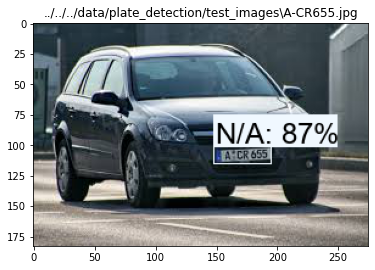

Box: [0.66084784 0.5816367  0.7500941  0.7632713 ]
Class: 0
Score: 0.8902636766433716
Detections: 1


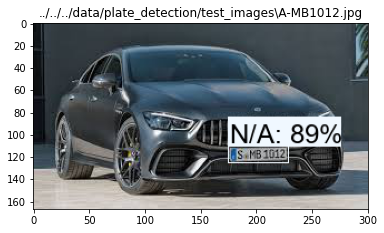

Box: [0.6386823  0.18760115 0.71955675 0.3687861 ]
Class: 0
Score: 0.722005307674408
Detections: 1


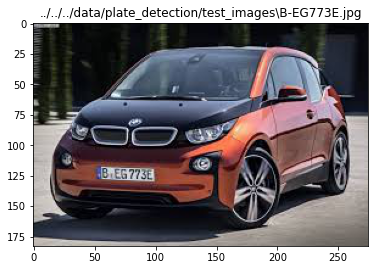

Box: [0.7445116  0.5060465  0.81584525 0.662175  ]
Class: 0
Score: 0.8361917734146118
Detections: 1


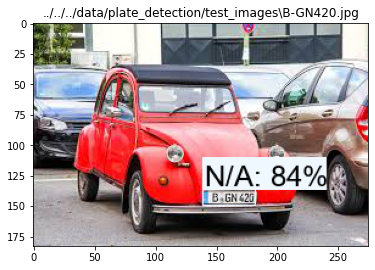

Box: [0.5054681  0.5015408  0.6706521  0.73617256]
Class: 0
Score: 0.9952458143234253
Detections: 1


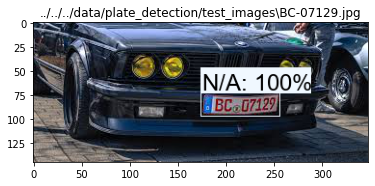

Box: [0.28801066 0.35297146 0.41398    0.6569748 ]
Class: 0
Score: 0.9986355900764465
Detections: 1


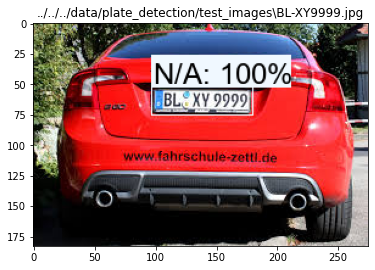

Box: [0.5141049  0.30920213 0.58783084 0.46696627]
Class: 0
Score: 0.8735560774803162
Detections: 1


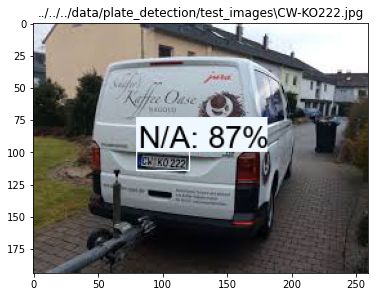

Box: [0.3692533 0.3361254 0.4470919 0.4614326]
Class: 0
Score: 0.8574399948120117
Detections: 1


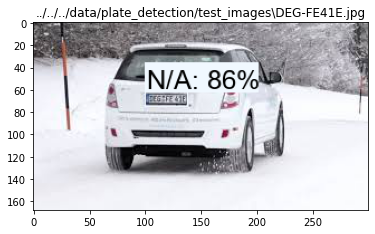

Box: [0.49361822 0.37822005 0.8917582  0.75684464]
Class: 0
Score: 0.9997936487197876
Detections: 1


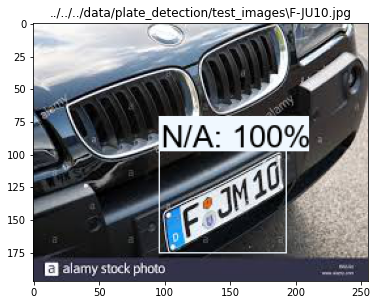

Box: [0.70417255 0.15649197 0.7970565  0.33037424]
Class: 0
Score: 0.9165619015693665
Detections: 1


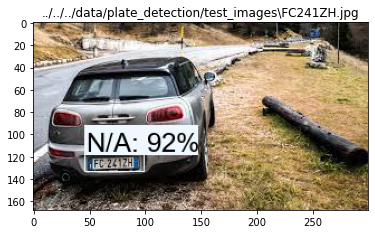

Box: [0.50856143 0.3508521  0.60809296 0.6927935 ]
Class: 0
Score: 0.9528563022613525
Detections: 1


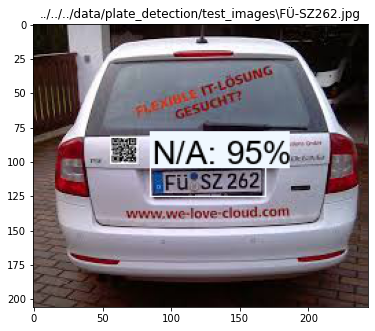

Box: [0.51730126 0.5506965  0.6023992  0.738899  ]
Class: 0
Score: 0.7367546558380127
Detections: 1


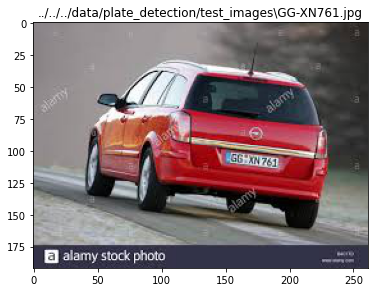

Box: [0.6527494  0.38444847 0.74127674 0.61828464]
Class: 0
Score: 0.9349836111068726
Detections: 1


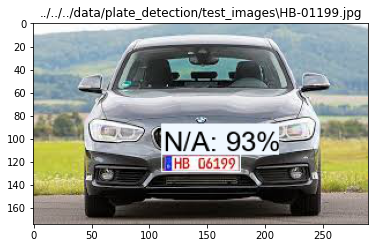

Box: [0.3346531  0.1524986  0.79344285 0.92316043]
Class: 0
Score: 0.9994329810142517
Detections: 1


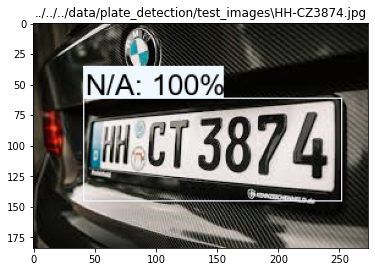

Box: [0.6276347  0.59756994 0.7147164  0.7780858 ]
Class: 0
Score: 0.7833203077316284
Detections: 1


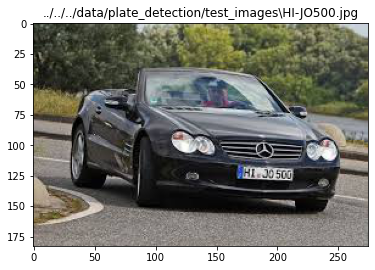

Box: [0.60566884 0.7474249  0.72410065 0.8857675 ]
Class: 0
Score: 0.9237250685691833
Detections: 1


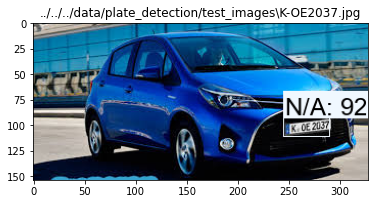

Box: [0.43653378 0.5761932  0.5871235  0.7777946 ]
Class: 0
Score: 0.9927511215209961
Detections: 1


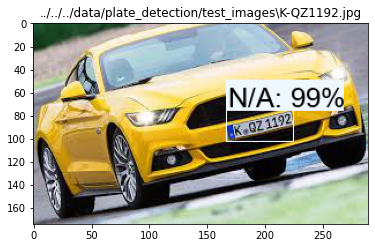

Box: [0.8008494  0.25259227 0.8663563  0.39209884]
Class: 0
Score: 0.4887343645095825
Detections: 1
Box: [0.60011965 0.64593464 0.68076414 0.79021853]
Class: 0
Score: 0.9578837156295776
Detections: 1


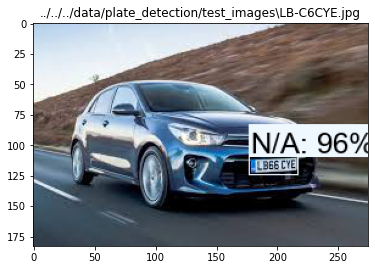

Box: [0.5305268  0.2388584  0.72004646 0.75149316]
Class: 0
Score: 0.9995478987693787
Detections: 1


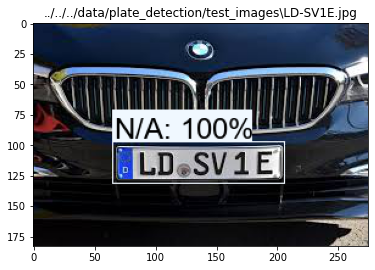

Box: [0.56090784 0.19511601 0.64717484 0.32086477]
Class: 0
Score: 0.9603765606880188
Detections: 1


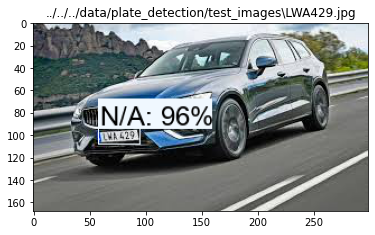

Box: [0.60565645 0.3633317  0.69498557 0.5190402 ]
Class: 0
Score: 0.9318732023239136
Detections: 1


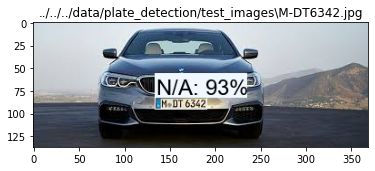

Box: [0.66414016 0.15631834 0.7759511  0.3489401 ]
Class: 0
Score: 0.9266842007637024
Detections: 1


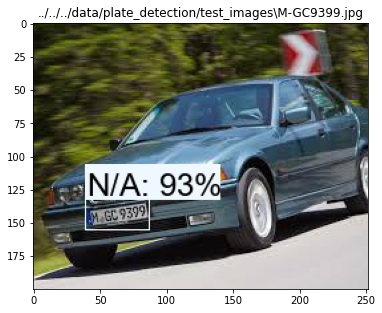

Box: [0.73599863 0.30679113 0.8008112  0.45208442]
Class: 0
Score: 0.9145359992980957
Detections: 1


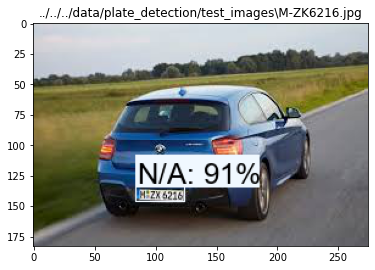

Box: [0.81753784 0.3216195  0.9323713  0.68063426]
Class: 0
Score: 0.9955401420593262
Detections: 1


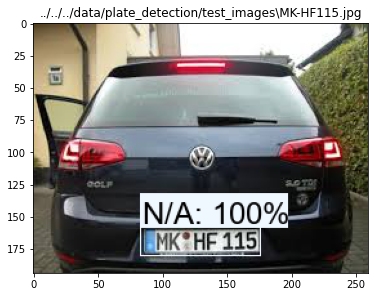

Box: [0.29179946 0.6962849  0.35549483 0.8776119 ]
Class: 0
Score: 0.7776505351066589
Detections: 1


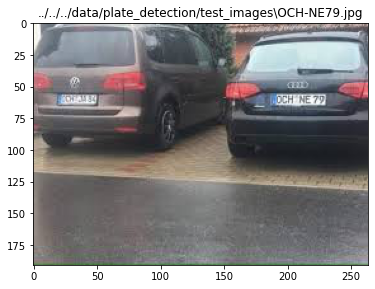

Box: [0.40447816 0.1754823  0.48419806 0.31160268]
Class: 0
Score: 0.8331201076507568
Detections: 1


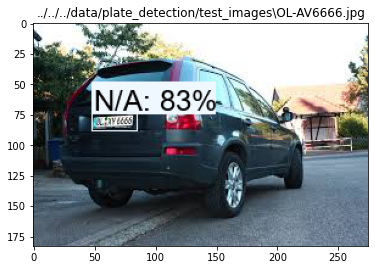

Box: [0.6697713  0.15825641 0.77438796 0.3267861 ]
Class: 0
Score: 0.8963866829872131
Detections: 1


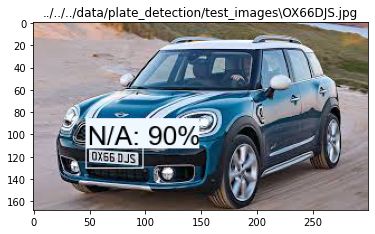

Box: [0.20057961 0.18181115 0.78571224 0.86096865]
Class: 0
Score: 0.9995169043540955
Detections: 1


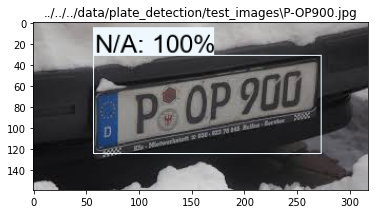

Box: [0.61878824 0.4697491  0.70553195 0.7012993 ]
Class: 0
Score: 0.8201542496681213
Detections: 1


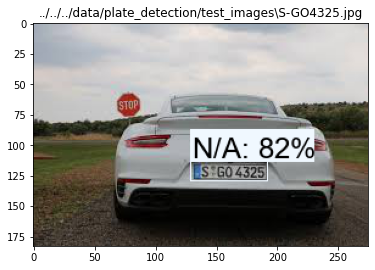

Box: [0.553785   0.6014118  0.6388007  0.74378335]
Class: 0
Score: 0.9100828170776367
Detections: 1


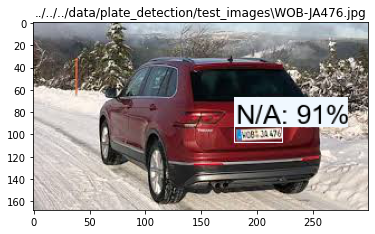

In [13]:
from object_detection.utils import visualization_utils as vis_util
from PIL import ImageOps

%matplotlib inline 

input_mean = 128
input_std = 128
    
for image_path in test_images:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image.resize((300, 300), Image.ANTIALIAS))
    input_data = np.array(np.expand_dims(image_np, axis=0), dtype=np.float32)
    input_data = (np.float32(input_data) - input_mean) / input_std

    interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    detection_box = np.squeeze(interpreter.tensor(output_details[0]['index'])())
    print("Box: {}".format(detection_box))

    detection_class = np.squeeze(interpreter.tensor(output_details[1]['index'])()).astype(np.uint8)
    print("Class: {}".format(detection_class))

    detection_score = np.squeeze(interpreter.tensor(output_details[2]['index'])())
    print("Score: {}".format(detection_score))

    num_detections = np.squeeze(interpreter.tensor(output_details[3]['index'])()).astype(int)
    print("Detections: {}".format(num_detections))

    if num_detections > 0 and detection_score > 0.5: 
        image_np = load_image_into_numpy_array(image)
        ymin, xmin, ymax, xmax = detection_box

        #vis_util.draw_bounding_box_on_image_array(image_np, ymin, xmin, ymax, xmax, color='red', thickness=1)            
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.array([detection_box]),
            np.array([detection_class]),
            np.array([detection_score]),
            category_index,
            #instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            max_boxes_to_draw=1,
            line_thickness=1,
            min_score_thresh=0.8)

        plt.figure(figsize=(6, 6))
        plt.title(image_path)
        plt.imshow(image_np)
        plt.show()